In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
data = pd.read_csv('./data/low_temp_overall.csv')
data.head()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h",gas_feed molecular weight,"gas_feed Mass density, kg/m3","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed mass heat capacity,gas_feed Methane mass frac,gas_feed Ethane mass frac,...,"17 actual liquid flow, m3/h","17 actual vapour flow, m3/h",17 mass heat capacity,17 Methane mass frac,17 Ethane mass frac,17 Propane mass frac,17 i-Butane mass frac,17 n-Butane mass frac,17 i-Pentane mass frac,17 n-Pentane mass frac
0,-23.0,4041.0,21277.0,23.956971,73.393036,18.015246,271.889646,2.552841,0.508804,0.071252,...,16.473024,0.671735,2.248443,0.055855,0.065350,0.159964,0.362796,0.318673,0.009351,0.028012
1,-11.0,4320.0,6634.0,28.122865,103.408737,7.785243,56.367944,2.562291,0.358629,0.128836,...,7.471808,0.002190,3.172211,0.000006,0.092802,0.051350,0.424403,0.380461,0.026824,0.024153
2,9.0,4299.0,22552.0,27.218717,79.662664,20.458362,262.635360,2.574080,0.375699,0.151103,...,18.949131,0.423676,2.593380,0.022762,0.091335,0.049298,0.296327,0.511004,0.008935,0.020340
3,-15.0,4214.0,9679.0,23.387540,70.663424,6.863007,130.110260,2.640162,0.498093,0.158571,...,6.564201,0.000000,3.120212,0.000004,0.117264,0.232341,0.524567,0.045849,0.047009,0.032967
4,-15.0,3757.0,7193.0,19.586848,42.874012,1.841248,165.929382,2.504826,0.740581,0.022713,...,2.215091,0.131402,2.214229,0.048311,0.015410,0.058774,0.532420,0.216966,0.099379,0.028739


In [4]:
## Рассчитываем массовые расходы отдельных компонентов
data.loc[:, 'gas_feed Methane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Methane mass frac']
data.loc[:, 'gas_feed Ethane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Ethane mass frac']
data.loc[:, 'gas_feed Propane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed Propane mass frac']
data.loc[:, 'gas_feed i-Butane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed i-Butane mass frac']
data.loc[:, 'gas_feed n-Butane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed n-Butane mass frac']
data.loc[:, 'gas_feed i-Pentane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed i-Pentane mass frac']
data.loc[:, 'gas_feed n-Pentane mass flow, kg/h'] = data['gas_feed mass flow, kg/h'] * data['gas_feed n-Pentane mass frac']

data.loc[:, '1 Methane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Methane mass frac']
data.loc[:, '1 Ethane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Ethane mass frac']
data.loc[:, '1 Propane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 Propane mass frac']
data.loc[:, '1 i-Butane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 i-Butane mass frac']
data.loc[:, '1 n-Butane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 n-Butane mass frac']
data.loc[:, '1 i-Pentane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 i-Pentane mass frac']
data.loc[:, '1 n-Pentane mass flow, kg/h'] = data['1 mass flow, kg/h'] * data['1 n-Pentane mass frac']

data.loc[:, '16 Methane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 Methane mass frac']
data.loc[:, '16 Ethane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 Ethane mass frac']
data.loc[:, '16 Propane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 Propane mass frac']
data.loc[:, '16 i-Butane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 i-Butane mass frac']
data.loc[:, '16 n-Butane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 n-Butane mass frac']
data.loc[:, '16 i-Pentane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 i-Pentane mass frac']
data.loc[:, '16 n-Pentane mass flow, kg/h'] = data['16 mass flow, kg/h'] * data['16 n-Pentane mass frac']

data.loc[:, '17 Methane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 Methane mass frac']
data.loc[:, '17 Ethane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 Ethane mass frac']
data.loc[:, '17 Propane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 Propane mass frac']
data.loc[:, '17 i-Butane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 i-Butane mass frac']
data.loc[:, '17 n-Butane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 n-Butane mass frac']
data.loc[:, '17 i-Pentane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 i-Pentane mass frac']
data.loc[:, '17 n-Pentane mass flow, kg/h'] = data['17 mass flow, kg/h'] * data['17 n-Pentane mass frac']

data.loc[:, '2 Methane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 Methane mass frac']
data.loc[:, '2 Ethane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 Ethane mass frac']
data.loc[:, '2 Propane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 Propane mass frac']
data.loc[:, '2 i-Butane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 i-Butane mass frac']
data.loc[:, '2 n-Butane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 n-Butane mass frac']
data.loc[:, '2 i-Pentane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 i-Pentane mass frac']
data.loc[:, '2 n-Pentane mass flow, kg/h'] = data['2 mass flow, kg/h'] * data['2 n-Pentane mass frac']

data.loc[:, '3 Methane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 Methane mass frac']
data.loc[:, '3 Ethane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 Ethane mass frac']
data.loc[:, '3 Propane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 Propane mass frac']
data.loc[:, '3 i-Butane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 i-Butane mass frac']
data.loc[:, '3 n-Butane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 n-Butane mass frac']
data.loc[:, '3 i-Pentane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 i-Pentane mass frac']
data.loc[:, '3 n-Pentane mass flow, kg/h'] = data['3 mass flow, kg/h'] * data['3 n-Pentane mass frac']

## Определение объемных расходов пара и жидкости сырьевого потока

In [4]:
feed_prod_vol_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

In [8]:
feed_prod_vol_flow_mini_data = feed_prod_vol_flow.sample(frac=0.005)
feed_prod_vol_flow_mini_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090 entries, 80845 to 260397
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gas_feed temperature, C            3090 non-null   float64
 1   gas_feed pressure, kPa             3090 non-null   float64
 2   gas_feed mass flow, kg/h           3090 non-null   float64
 3   gas_feed actual liquid flow, m3/h  3090 non-null   float64
 4   gas_feed actual vapour flow, m3/h  3090 non-null   float64
 5   gas_feed Methane mass frac         3090 non-null   float64
 6   gas_feed Ethane mass frac          3090 non-null   float64
 7   gas_feed Propane mass frac         3090 non-null   float64
 8   gas_feed i-Butane mass frac        3090 non-null   float64
 9   gas_feed n-Butane mass frac        3090 non-null   float64
 10  gas_feed i-Pentane mass frac       3090 non-null   float64
 11  gas_feed n-Pentane mass frac       3090 non-null  

In [9]:
feed_prod_vol_flow_mini_data.to_csv('feed_prod_vol_flow_data.csv')

In [4]:
feed_prod_vol_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832


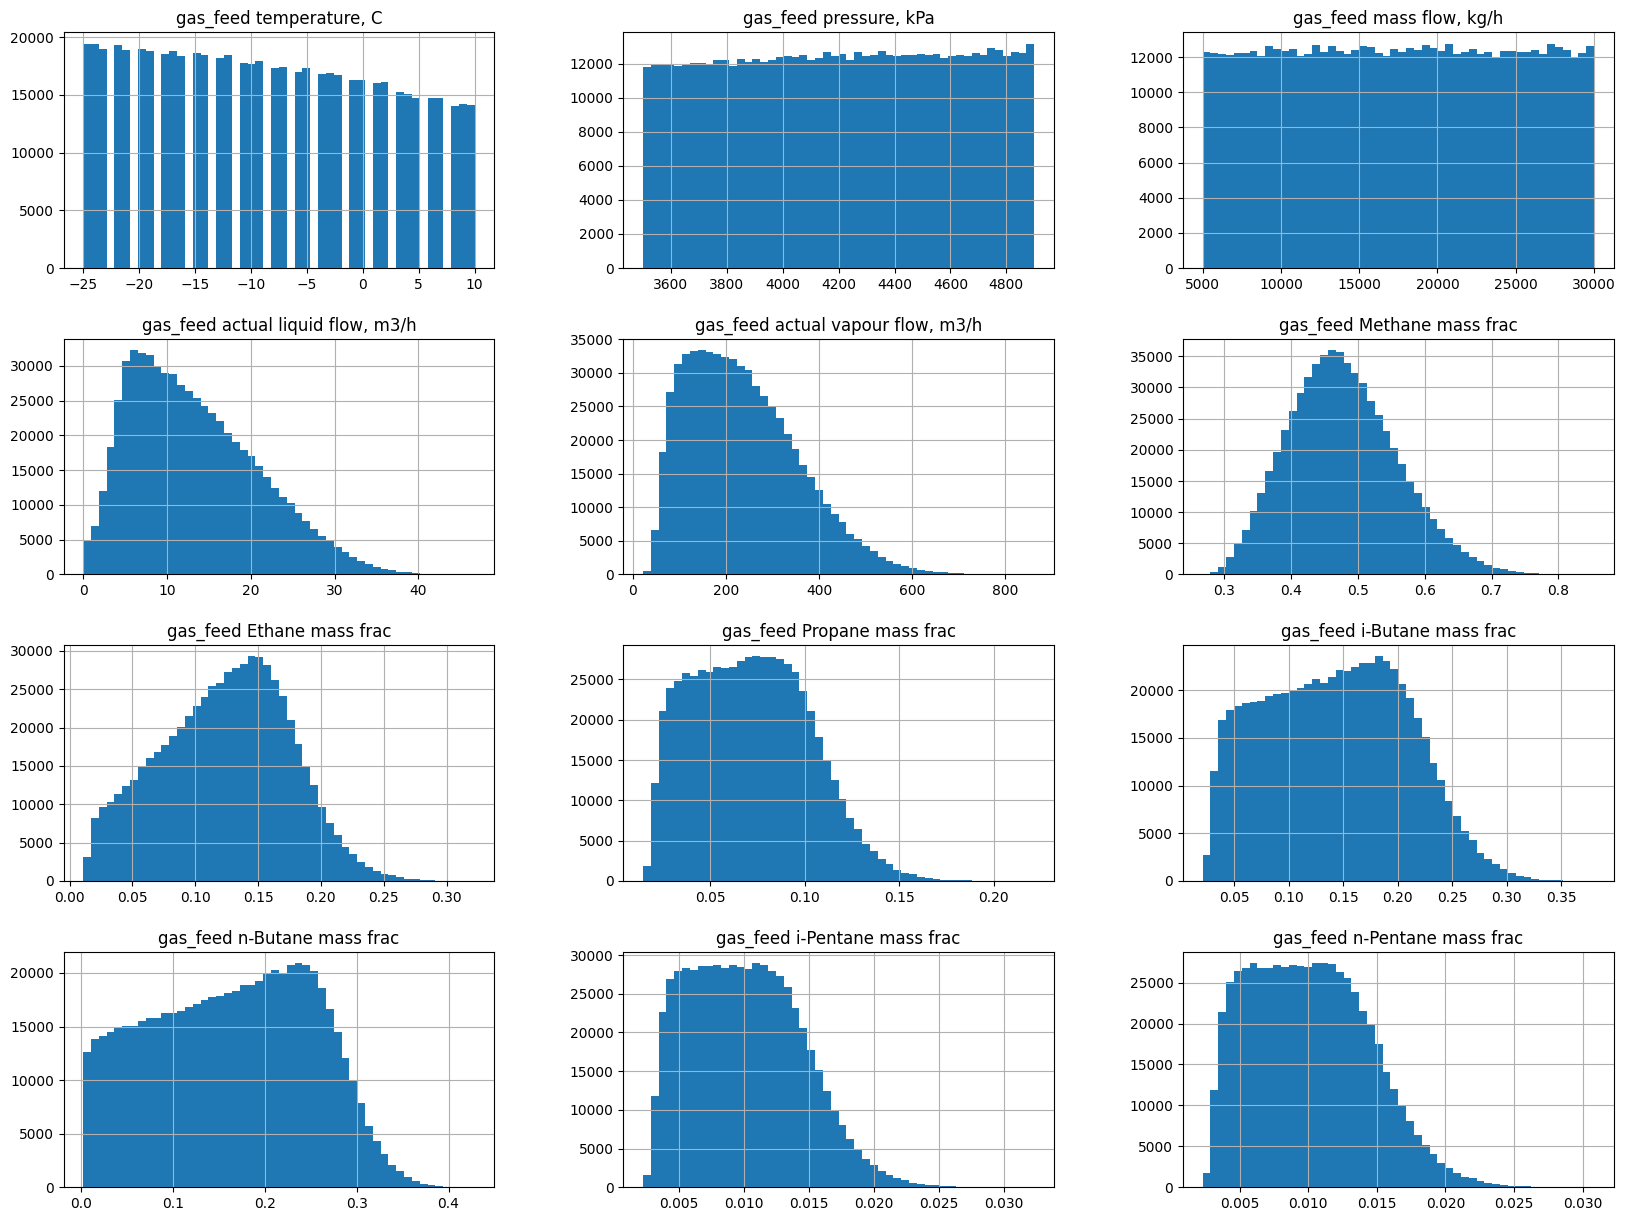

In [5]:
feed_prod_vol_flow.hist(bins=50, figsize=(20, 15));

In [6]:
corr_matrix = feed_prod_vol_flow.corr()

corr_matrix['gas_feed actual liquid flow, m3/h'].sort_values(ascending=False)

gas_feed actual liquid flow, m3/h    1.000000
gas_feed mass flow, kg/h             0.723261
gas_feed n-Butane mass frac          0.397954
gas_feed actual vapour flow, m3/h    0.225261
gas_feed i-Butane mass frac          0.214191
gas_feed pressure, kPa               0.093939
gas_feed Propane mass frac          -0.009964
gas_feed Ethane mass frac           -0.058984
gas_feed i-Pentane mass frac        -0.087376
gas_feed n-Pentane mass frac        -0.090083
gas_feed temperature, C             -0.238838
gas_feed Methane mass frac          -0.548213
Name: gas_feed actual liquid flow, m3/h, dtype: float64

In [7]:
## Тестовая и обучающая выборки
X = feed_prod_vol_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

y = feed_prod_vol_flow[[
    'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 10), (494360, 2))

In [8]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
feed_prod_vol_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
feed_prod_vol_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
feed_prod_vol_flow_model.fit(X_train_normal, y_train, epochs=40)

Epoch 1/40
15449/15449 [==============================] - 31s 2ms/step - loss: 2.2094 - mae: 2.2094
Epoch 2/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.9969 - mae: 0.9969
Epoch 3/40
15449/15449 [==============================] - 32s 2ms/step - loss: 0.8725 - mae: 0.8725
Epoch 4/40
15449/15449 [==============================] - 50s 3ms/step - loss: 0.7854 - mae: 0.7854
Epoch 5/40
15449/15449 [==============================] - 39s 2ms/step - loss: 0.7297 - mae: 0.7297
Epoch 6/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6990 - mae: 0.6990
Epoch 7/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6505 - mae: 0.6505
Epoch 8/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.6296 - mae: 0.6296
Epoch 9/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5921 - mae: 0.5921
Epoch 10/40
15449/15449 [==============================] - 41s 3ms/step - loss: 0.5677 - mae: 0.5677

In [9]:
y_pred = feed_prod_vol_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 1ms/step


In [10]:
x = 156
pred = y_pred[x]
pred

array([  6.8597426, 349.4037   ], dtype=float32)

In [11]:
test = y_test.iloc[x]
test

gas_feed actual liquid flow, m3/h      6.926595
gas_feed actual vapour flow, m3/h    348.885917
Name: 30381, dtype: float64

In [13]:
feed_prod_vol_flow_model.save('./models/low_temp_dist_24_04/feed_prod_vol_flow_model.h5')

## Определение массовых расходов продуктов сепаратора

In [40]:
list(data.columns)

['gas_feed temperature, C',
 'gas_feed pressure, kPa',
 'gas_feed mass flow, kg/h',
 'gas_feed molecular weight',
 'gas_feed Mass density, kg/m3',
 'gas_feed actual liquid flow, m3/h',
 'gas_feed actual vapour flow, m3/h',
 'gas_feed mass heat capacity',
 'gas_feed Methane mass frac',
 'gas_feed Ethane mass frac',
 'gas_feed Propane mass frac',
 'gas_feed i-Butane mass frac',
 'gas_feed n-Butane mass frac',
 'gas_feed i-Pentane mass frac',
 'gas_feed n-Pentane mass frac',
 'Q-104',
 'Q-100',
 'Comp Fraction',
 '1 temperature, C',
 '1 pressure, kPa',
 '1 mass flow, kg/h',
 '1 molecular weight',
 '1 Mass density, kg/m3',
 '1 actual liquid flow, m3/h',
 '1 actual vapour flow, m3/h',
 '1 mass heat capacity',
 '1 Methane mass frac',
 '1 Ethane mass frac',
 '1 Propane mass frac',
 '1 i-Butane mass frac',
 '1 n-Butane mass frac',
 '1 i-Pentane mass frac',
 '1 n-Pentane mass frac',
 '2 temperature, C',
 '2 pressure, kPa',
 '2 mass flow, kg/h',
 '2 molecular weight',
 '2 Mass density, kg/m3',
 

In [41]:
sep_prod_mass_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    'gas_feed Methane mass flow, kg/h', 'gas_feed Ethane mass flow, kg/h',
    'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h', 'gas_feed n-Butane mass flow, kg/h',
    'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 mass flow, kg/h'    
]]

In [42]:
sep_prod_mass_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac,"gas_feed Methane mass flow, kg/h","gas_feed Ethane mass flow, kg/h","gas_feed Propane mass flow, kg/h","gas_feed i-Butane mass flow, kg/h","gas_feed n-Butane mass flow, kg/h","gas_feed i-Pentane mass flow, kg/h","gas_feed n-Pentane mass flow, kg/h","1 mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102,8368.071731,2165.994708,1250.641303,2506.828791,2867.810659,177.254210,176.808764,10708.440240
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274,3768.246429,1315.730331,772.560657,1597.788933,2025.759082,109.072920,108.743809,5156.225297
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290,1426.422317,63.634031,82.487167,118.030206,15.730002,13.214753,12.855270,1178.371232
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578,5244.043193,1109.398345,642.248103,1229.723963,1248.842612,92.130994,92.139255,6520.828264
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854,8133.060505,1920.199072,1074.288011,2148.146685,2430.556725,152.006489,151.836292,10148.332833
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138,11104.890655,3023.595741,1716.144730,3499.218049,4163.939477,241.709317,240.614747,14193.118168
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832,23957.129684,8801.875070,5511.003804,10551.245203,11520.205130,898.411830,816.134230,29970.000000


In [43]:
sep_prod_mass_flow_mini_data = sep_prod_mass_flow.sample(frac=0.002)
sep_prod_mass_flow_mini_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 305948 to 102652
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gas_feed temperature, C             1236 non-null   float64
 1   gas_feed pressure, kPa              1236 non-null   float64
 2   gas_feed mass flow, kg/h            1236 non-null   float64
 3   gas_feed actual liquid flow, m3/h   1236 non-null   float64
 4   gas_feed actual vapour flow, m3/h   1236 non-null   float64
 5   gas_feed Methane mass frac          1236 non-null   float64
 6   gas_feed Ethane mass frac           1236 non-null   float64
 7   gas_feed Propane mass frac          1236 non-null   float64
 8   gas_feed i-Butane mass frac         1236 non-null   float64
 9   gas_feed n-Butane mass frac         1236 non-null   float64
 10  gas_feed i-Pentane mass frac        1236 non-null   float64
 11  gas_feed n-Pentane mass frac        

In [44]:
sep_prod_mass_flow_mini_data.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac,"gas_feed Methane mass flow, kg/h","gas_feed Ethane mass flow, kg/h","gas_feed Propane mass flow, kg/h","gas_feed i-Butane mass flow, kg/h","gas_feed n-Butane mass flow, kg/h","gas_feed i-Pentane mass flow, kg/h","gas_feed n-Pentane mass flow, kg/h","1 mass flow, kg/h"
count,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000
mean,-8.523463,4198.367314,17297.230583,13.062704,236.072823,0.479589,0.122267,0.071907,0.144693,0.161366,0.010085,0.010094,8296.380785,2116.593850,1254.027430,2496.473775,2784.681801,174.476838,174.596102,10626.620953
std,10.176910,398.946466,7188.081800,7.561563,119.554663,0.081362,0.051354,0.030401,0.063798,0.088559,0.004154,0.004345,3758.674002,1313.075568,793.587099,1576.544542,2025.687278,106.004746,107.984584,5132.163078
min,-25.000000,3505.000000,5006.000000,0.763346,26.246933,0.284825,0.012439,0.017896,0.024641,0.003409,0.002695,0.002503,1525.329518,105.662897,117.705868,133.509801,49.469154,15.474211,16.357263,1419.005908
25%,-17.000000,3860.000000,11213.500000,6.873089,139.392527,0.420986,0.084201,0.047046,0.092577,0.087642,0.006798,0.006627,5235.900323,1037.626467,629.553490,1192.139071,1142.609322,90.557124,88.656944,6525.395084
50%,-9.000000,4188.500000,17432.000000,11.536296,217.534884,0.477535,0.122635,0.070828,0.146062,0.162056,0.009909,0.009921,8075.085383,1891.951929,1069.536515,2213.183646,2347.756814,153.816603,152.773226,10144.091793
75%,0.000000,4555.500000,23435.000000,17.947392,314.593639,0.533941,0.159084,0.093445,0.193057,0.233051,0.013041,0.013203,10974.076509,2894.180693,1708.569396,3498.001201,4053.498416,235.572204,238.013169,14312.872225
max,10.000000,4900.000000,29967.000000,40.628402,668.519416,0.777193,0.270196,0.167135,0.321261,0.357324,0.024070,0.025715,22171.118826,6561.024341,4074.411773,7795.368377,9698.401962,613.449790,588.886081,27799.779459


In [45]:
sep_prod_mass_flow_mini_data.to_csv('sep_prod_mass_flow.csv')

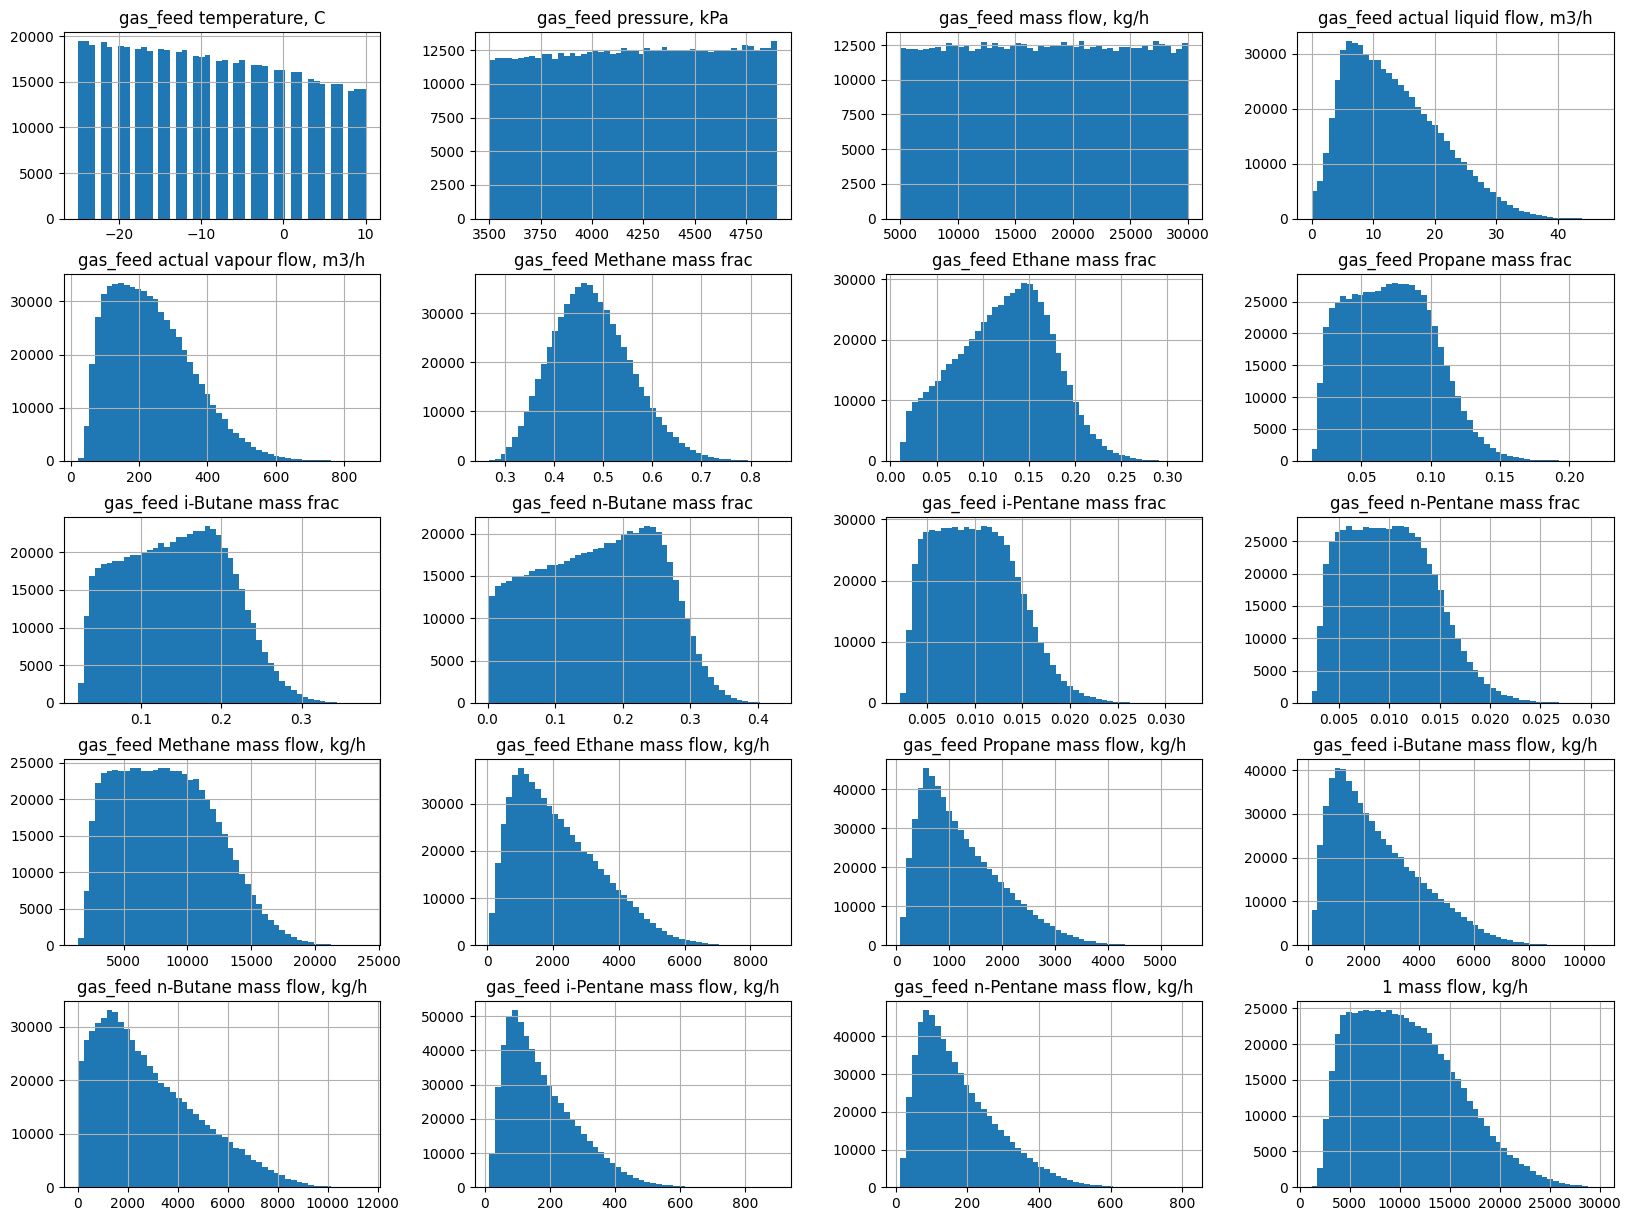

In [46]:
sep_prod_mass_flow.hist(bins=50, figsize=(20, 15));

In [47]:
corr_matrix = sep_prod_mass_flow.corr()

corr_matrix['1 mass flow, kg/h'].sort_values(ascending=False)

1 mass flow, kg/h                     1.000000
gas_feed actual vapour flow, m3/h     0.964563
gas_feed Methane mass flow, kg/h      0.958937
gas_feed mass flow, kg/h              0.854649
gas_feed Ethane mass flow, kg/h       0.635566
gas_feed i-Pentane mass flow, kg/h    0.624174
gas_feed n-Pentane mass flow, kg/h    0.622671
gas_feed Propane mass flow, kg/h      0.583553
gas_feed i-Butane mass flow, kg/h     0.422647
gas_feed Methane mass frac            0.404069
gas_feed actual liquid flow, m3/h     0.260942
gas_feed n-Butane mass flow, kg/h     0.220884
gas_feed temperature, C               0.187186
gas_feed Ethane mass frac             0.072754
gas_feed i-Pentane mass frac          0.064500
gas_feed n-Pentane mass frac          0.061846
gas_feed Propane mass frac            0.015669
gas_feed pressure, kPa               -0.045402
gas_feed i-Butane mass frac          -0.155920
gas_feed n-Butane mass frac          -0.314609
Name: 1 mass flow, kg/h, dtype: float64

In [48]:
## Тестовая и обучающая выборки
X = sep_prod_mass_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    'gas_feed Methane mass flow, kg/h', 'gas_feed Ethane mass flow, kg/h',
    'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h', 'gas_feed n-Butane mass flow, kg/h',
    'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
]]

y = sep_prod_mass_flow[['1 mass flow, kg/h']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    'gas_feed Methane mass flow, kg/h', 'gas_feed Ethane mass flow, kg/h',
    'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h', 'gas_feed n-Butane mass flow, kg/h',
    'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 19), (494360, 1))

In [50]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_prod_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(19, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sep_prod_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_prod_mass_flow_model.fit(X_train_normal, y_train, epochs=100)

Epoch 1/100
15449/15449 [==============================] - 23s 1ms/step - loss: 263.9053 - mae: 263.9053
Epoch 2/100
15449/15449 [==============================] - 24s 2ms/step - loss: 24.5385 - mae: 24.5385
Epoch 3/100
15449/15449 [==============================] - 23s 1ms/step - loss: 19.3555 - mae: 19.3555
Epoch 4/100
15449/15449 [==============================] - 24s 2ms/step - loss: 17.5859 - mae: 17.5859
Epoch 5/100
15449/15449 [==============================] - 23s 2ms/step - loss: 16.7748 - mae: 16.7748
Epoch 6/100
15449/15449 [==============================] - 23s 1ms/step - loss: 16.0493 - mae: 16.0493
Epoch 7/100
15449/15449 [==============================] - 23s 1ms/step - loss: 15.6457 - mae: 15.6457
Epoch 8/100
15449/15449 [==============================] - 23s 1ms/step - loss: 15.2725 - mae: 15.2725
Epoch 9/100
15449/15449 [==============================] - 23s 1ms/step - loss: 15.1687 - mae: 15.1687
Epoch 10/100
15449/15449 [==============================] - 24s 2ms/ste

15449/15449 [==============================] - 35s 2ms/step - loss: 11.1405 - mae: 11.1405
Epoch 80/100
15449/15449 [==============================] - 28s 2ms/step - loss: 11.4037 - mae: 11.4037
Epoch 81/100
15449/15449 [==============================] - 25s 2ms/step - loss: 11.3665 - mae: 11.3665
Epoch 82/100
15449/15449 [==============================] - 25s 2ms/step - loss: 11.3342 - mae: 11.3342
Epoch 83/100
15449/15449 [==============================] - 29s 2ms/step - loss: 11.2237 - mae: 11.2237
Epoch 84/100
15449/15449 [==============================] - 37s 2ms/step - loss: 11.1860 - mae: 11.1860
Epoch 85/100
15449/15449 [==============================] - 31s 2ms/step - loss: 10.9637 - mae: 10.9637
Epoch 86/100
15449/15449 [==============================] - 36s 2ms/step - loss: 11.3927 - mae: 11.3927
Epoch 87/100
15449/15449 [==============================] - 61s 4ms/step - loss: 11.1023 - mae: 11.1023
Epoch 88/100
15449/15449 [==============================] - 40s 3ms/step - lo

In [51]:
y_pred = sep_prod_mass_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 4s 878us/step


In [69]:
x = 2348
pred = y_pred[x]
pred

array([2515.029], dtype=float32)

In [70]:
test = y_test.iloc[x]
test

1 mass flow, kg/h    2502.211207
Name: 434532, dtype: float64

In [71]:
sum(pred)

2515.029052734375

In [55]:
sep_prod_mass_flow_model.save('./models/low_temp_dist_24_04/sep_prod_mass_flow_model.h5')

## Определение состава продуктов сепаратора

In [15]:
sep_prod_comp = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
    '1 Methane mass flow, kg/h', '1 Ethane mass flow, kg/h', '1 Propane mass flow, kg/h', '1 i-Butane mass flow, kg/h',
    '1 n-Butane mass flow, kg/h', '1 i-Pentane mass flow, kg/h', '1 n-Pentane mass flow, kg/h'
]]

In [16]:
# sep_prod_comp_sample = sep_prod_comp.sample(frac=0.7)

In [17]:
sep_prod_comp.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,...,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h","1 Methane mass flow, kg/h","1 Ethane mass flow, kg/h","1 Propane mass flow, kg/h","1 i-Butane mass flow, kg/h","1 n-Butane mass flow, kg/h","1 i-Pentane mass flow, kg/h","1 n-Pentane mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,...,-8.480579,4207.666418,10708.440240,7632.388741,1460.298519,517.565783,589.143102,471.614328,20.746357,16.683410
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,...,10.266356,403.397921,5156.225297,3614.775361,990.738355,424.436118,502.295492,384.349698,29.766231,26.292927
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,...,-25.000000,3500.000000,1178.371232,880.888195,29.271809,14.877799,8.414354,1.505019,0.210124,0.177216
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,...,-17.000000,3860.000000,6520.828264,4687.393010,704.857361,222.580618,241.889471,196.335571,5.721252,4.311031
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,...,-9.000000,4211.000000,10148.332833,7276.421479,1233.954705,395.241341,439.921803,364.488321,11.569586,8.797048
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,...,0.000000,4557.000000,14193.118168,10119.317074,1990.463164,678.562980,772.651250,633.447974,23.585255,18.377524
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,...,10.000000,4900.000000,29970.000000,23882.854503,8210.145468,5160.041992,5662.226921,3388.108050,675.411675,591.001933


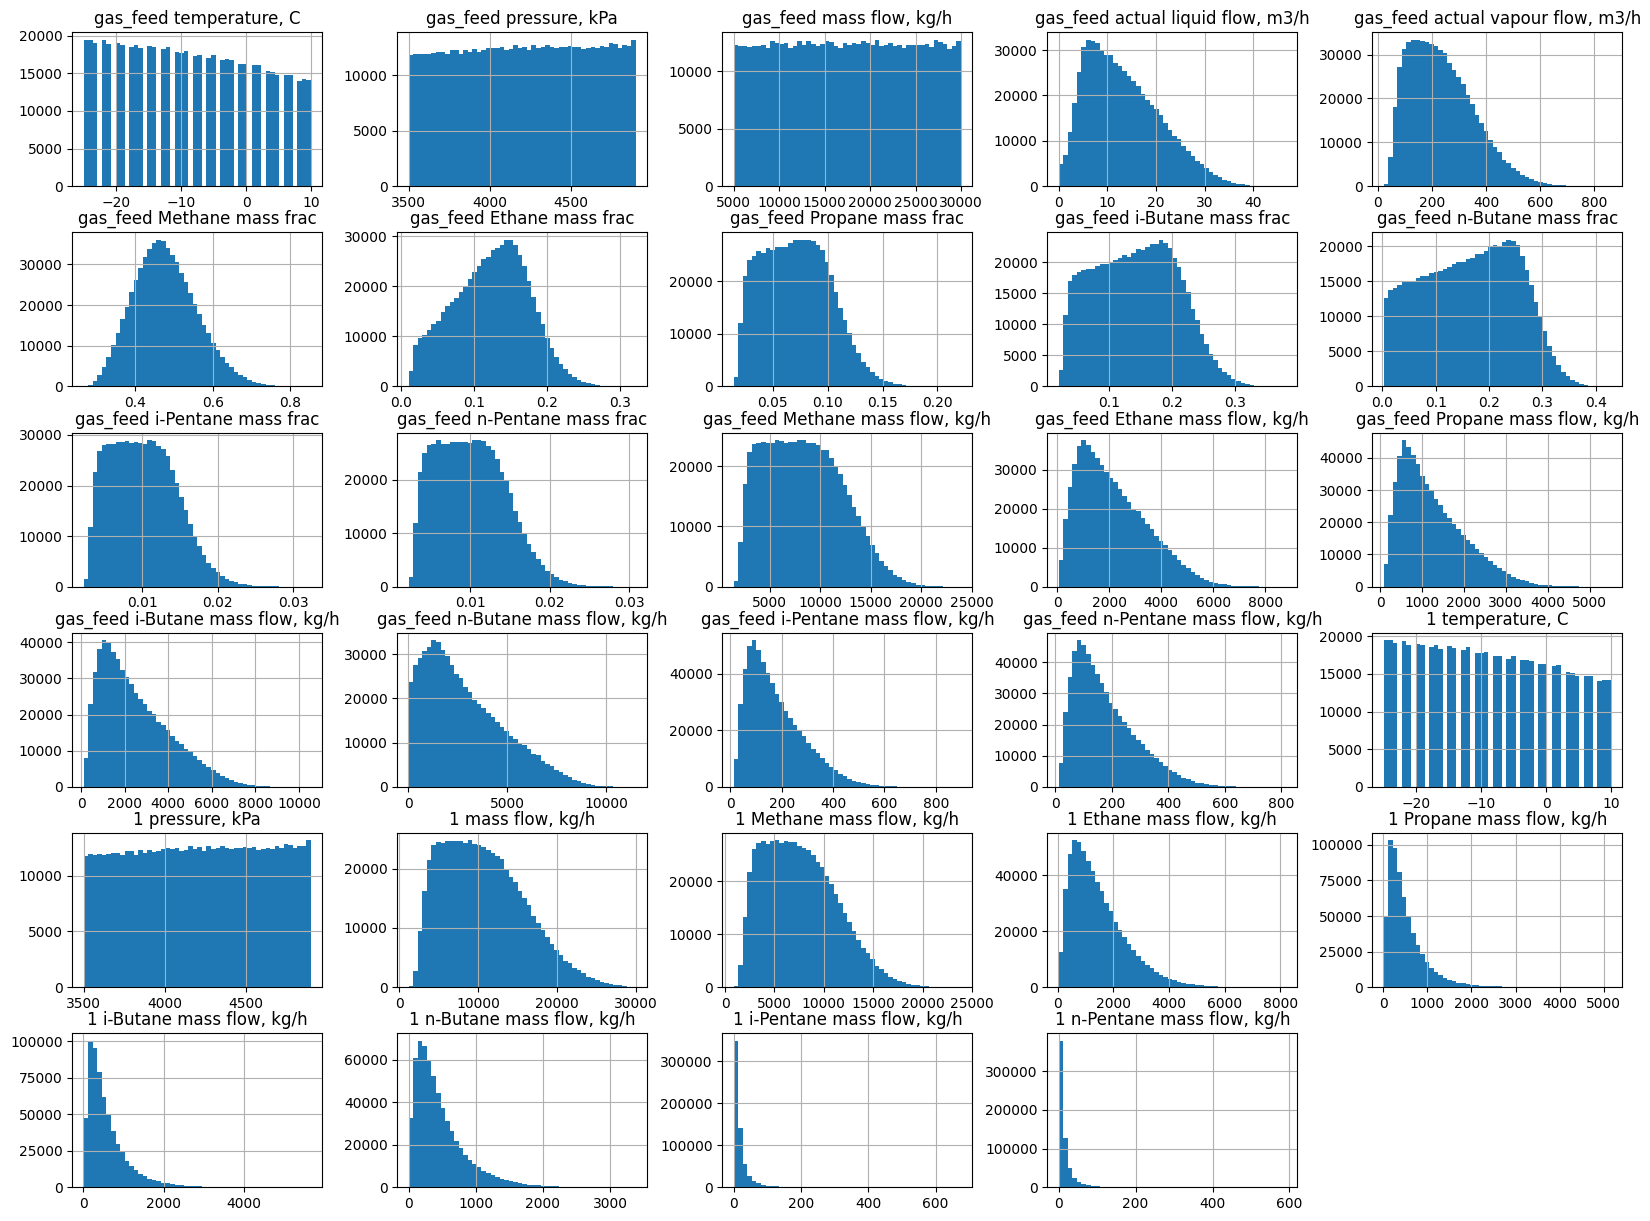

In [18]:
sep_prod_comp.hist(bins=50, figsize=(20, 15));

In [19]:
corr_matrix = sep_prod_comp.corr()

corr_matrix['1 Methane mass flow, kg/h'].sort_values(ascending=False)

1 Methane mass flow, kg/h             1.000000
gas_feed Methane mass flow, kg/h      0.992623
1 mass flow, kg/h                     0.975638
gas_feed actual vapour flow, m3/h     0.945467
gas_feed mass flow, kg/h              0.868608
1 Propane mass flow, kg/h             0.658732
gas_feed i-Pentane mass flow, kg/h    0.635667
gas_feed n-Pentane mass flow, kg/h    0.634248
1 Ethane mass flow, kg/h              0.620798
1 i-Butane mass flow, kg/h            0.596967
gas_feed Propane mass flow, kg/h      0.574703
gas_feed Ethane mass flow, kg/h       0.534483
1 i-Pentane mass flow, kg/h           0.518957
1 n-Butane mass flow, kg/h            0.502327
1 n-Pentane mass flow, kg/h           0.487702
gas_feed Methane mass frac            0.451633
gas_feed i-Butane mass flow, kg/h     0.435488
gas_feed actual liquid flow, m3/h     0.313278
gas_feed n-Butane mass flow, kg/h     0.265541
gas_feed i-Pentane mass frac          0.067116
gas_feed n-Pentane mass frac          0.064797
gas_feed temp

In [20]:
## Тестовая и обучающая выборки
X = sep_prod_comp[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
]]

y = sep_prod_comp[[
    '1 Methane mass flow, kg/h', '1 Ethane mass flow, kg/h', '1 Propane mass flow, kg/h', '1 i-Butane mass flow, kg/h',
    '1 n-Butane mass flow, kg/h', '1 i-Pentane mass flow, kg/h', '1 n-Pentane mass flow, kg/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 22), (494360, 7))

In [21]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_top_prod_comp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(22, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(7)
])

# 2. Compile the model
sep_top_prod_comp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_top_prod_comp_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
15449/15449 [==============================] - 33s 2ms/step - loss: 158.4568 - mae: 158.4568
Epoch 2/50
15449/15449 [==============================] - 33s 2ms/step - loss: 63.5656 - mae: 63.5656
Epoch 3/50
15449/15449 [==============================] - 34s 2ms/step - loss: 18.7423 - mae: 18.7423
Epoch 4/50
15449/15449 [==============================] - 37s 2ms/step - loss: 15.7730 - mae: 15.7730
Epoch 5/50
15449/15449 [==============================] - 36s 2ms/step - loss: 14.2374 - mae: 14.2374
Epoch 6/50
15449/15449 [==============================] - 36s 2ms/step - loss: 13.2169 - mae: 13.2169
Epoch 7/50
15449/15449 [==============================] - 33s 2ms/step - loss: 12.4242 - mae: 12.4242
Epoch 8/50
15449/15449 [==============================] - 35s 2ms/step - loss: 11.6810 - mae: 11.6810
Epoch 9/50
15449/15449 [==============================] - 34s 2ms/step - loss: 10.7335 - mae: 10.7335
Epoch 10/50
15449/15449 [==============================] - 34s 2ms/step - loss: 

In [22]:
y_pred = sep_top_prod_comp_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 922us/step


In [51]:
x = 895
pred = y_pred[x]
list(pred)

[10654.608, 2629.2659, 815.09894, 737.9021, 415.4418, 85.968956, 35.686207]

In [52]:
test = y_test.iloc[x]
test

1 Methane mass flow, kg/h      10641.301187
1 Ethane mass flow, kg/h        2640.757075
1 Propane mass flow, kg/h        813.089767
1 i-Butane mass flow, kg/h       751.438902
1 n-Butane mass flow, kg/h       413.195106
1 i-Pentane mass flow, kg/h       82.868358
1 n-Pentane mass flow, kg/h       37.537710
Name: 284960, dtype: float64

In [53]:
sum(list(test.values))

15380.188105736208

In [54]:
sum(list(pred))

15373.972270965576

In [55]:
sum(list(test.values)) - sum(list(pred))

6.215834770631773

In [56]:
list(list(pred) / sum(list(pred)))

[0.693029,
 0.17102058,
 0.053018108,
 0.04799684,
 0.02702241,
 0.0055918503,
 0.0023212093]

In [57]:
list(list(test.values) / sum(list(test.values)))

[0.6918836827182948,
 0.17169862012162115,
 0.05286604829176431,
 0.04885758853274871,
 0.026865413053724706,
 0.0053879937999977015,
 0.002440653481848601]

In [58]:
sep_top_prod_comp_model.save('./models/low_temp_dist_24_04/sep_top_prod_comp_model.h5')

## Определение температуры газа после детандера

In [60]:
expander_gas_temp_data = data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
]]

In [61]:
expander_gas_temp_data.describe()

,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h",1 Methane mass frac,1 Ethane mass frac,1 Propane mass frac,1 i-Butane mass frac,1 n-Butane mass frac,1 i-Pentane mass frac,1 n-Pentane mass frac,"3 temperature, C","3 pressure, kPa"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,10708.440240,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,-31.102971,2299.671637
std,10.266356,403.397921,5156.225297,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,11.950149,173.395338
min,-25.000000,3500.000000,1178.371232,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,-61.649513,2000.000000
25%,-17.000000,3860.000000,6520.828264,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,-40.574609,2149.000000
50%,-9.000000,4211.000000,10148.332833,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,-31.355123,2300.000000
75%,0.000000,4557.000000,14193.118168,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,-21.658693,2450.000000
max,10.000000,4900.000000,29970.000000,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,-0.570558,2600.000000


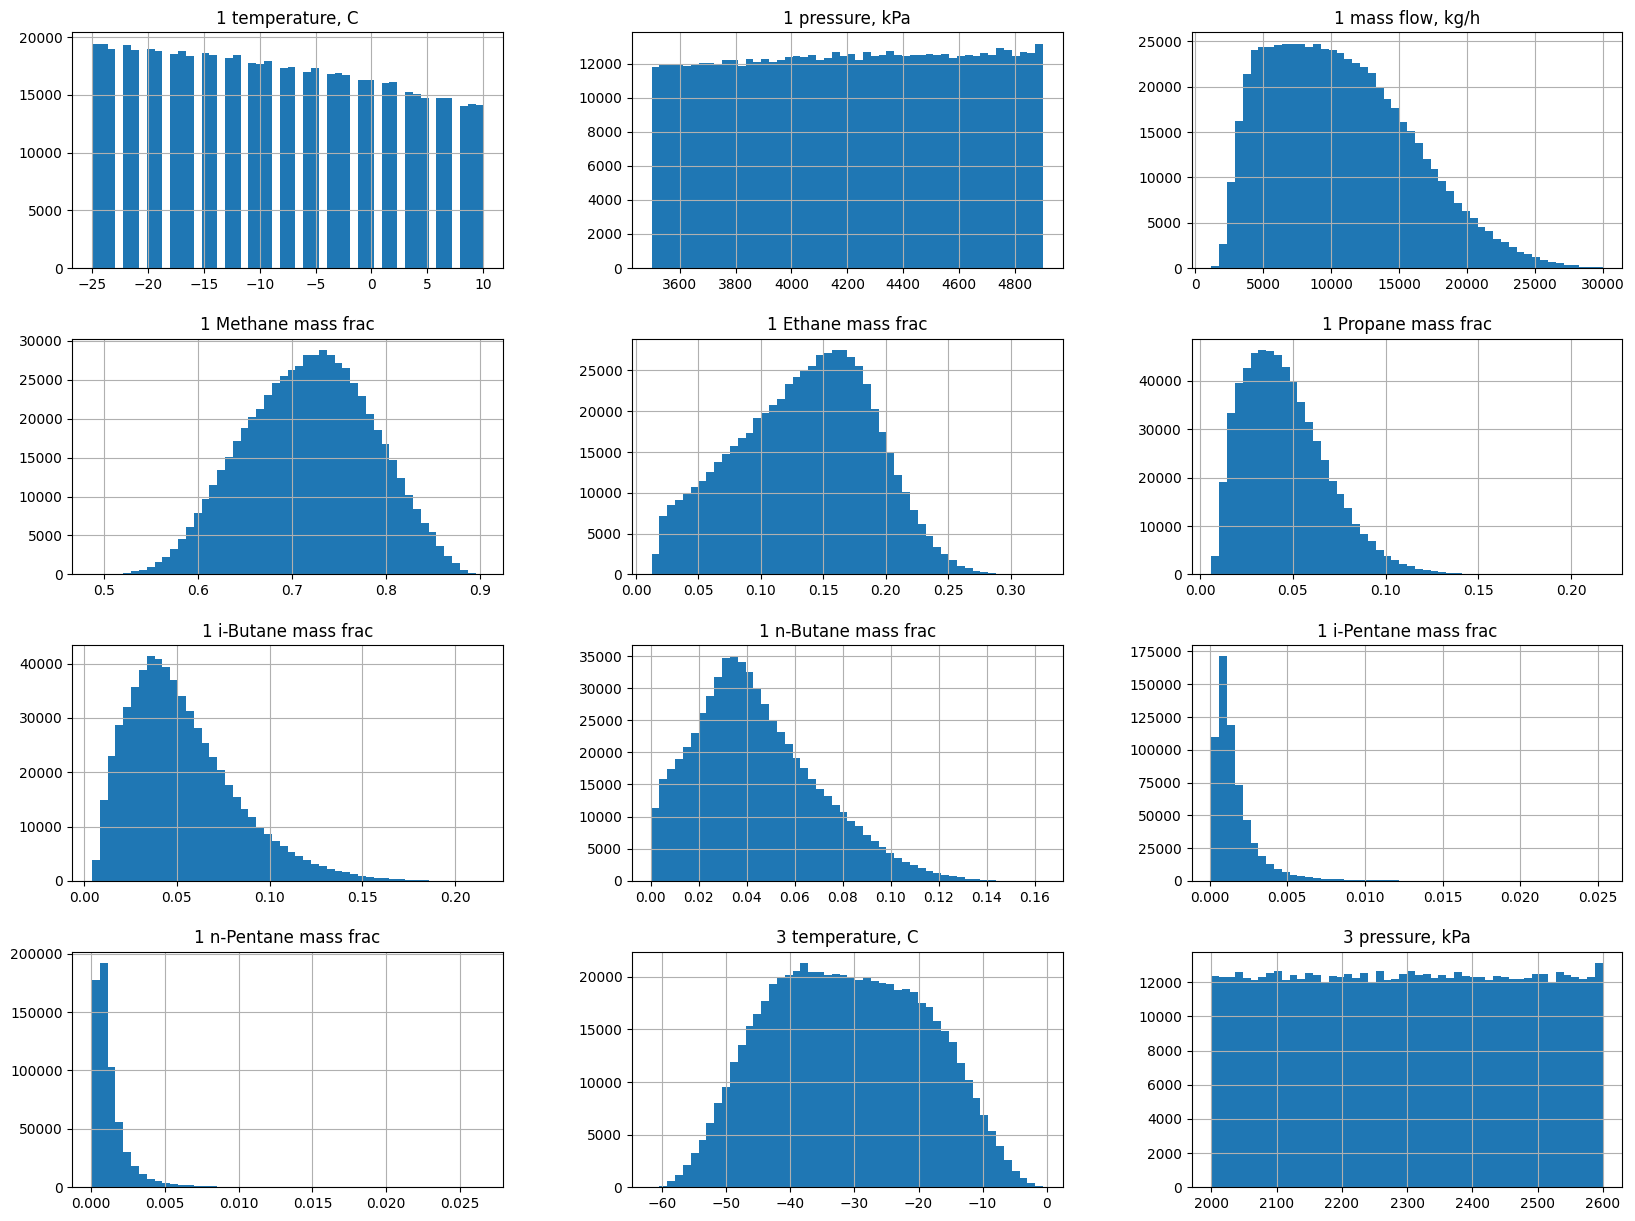

In [62]:
expander_gas_temp_data.hist(bins=50, figsize=(20, 15));

In [63]:
corr_matrix = expander_gas_temp_data.corr()

corr_matrix['3 temperature, C'].sort_values(ascending=False)

3 temperature, C         1.000000
1 temperature, C         0.919709
1 n-Butane mass frac     0.543180
1 i-Butane mass frac     0.526962
1 i-Pentane mass frac    0.429530
1 n-Pentane mass frac    0.419068
1 Propane mass frac      0.370986
3 pressure, kPa          0.219673
1 mass flow, kg/h        0.184937
1 Ethane mass frac       0.161731
1 pressure, kPa         -0.311847
1 Methane mass frac     -0.713120
Name: 3 temperature, C, dtype: float64

In [64]:
## Тестовая и обучающая выборки
X = expander_gas_temp_data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 pressure, kPa'
]]

y = expander_gas_temp_data[[
    '3 temperature, C'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 pressure, kPa'
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 11), (494360, 1))

In [65]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
expander_gas_temp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
expander_gas_temp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
expander_gas_temp_model.fit(X_train_normal, y_train, epochs=10)

Epoch 1/10
15449/15449 [==============================] - 33s 2ms/step - loss: 0.4054 - mae: 0.4054
Epoch 2/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.2245 - mae: 0.2245
Epoch 3/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1899 - mae: 0.1899
Epoch 4/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1710 - mae: 0.1710
Epoch 5/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1573 - mae: 0.1573
Epoch 6/10
15449/15449 [==============================] - 37s 2ms/step - loss: 0.1463 - mae: 0.1463
Epoch 7/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.1361 - mae: 0.1361
Epoch 8/10
15449/15449 [==============================] - 41s 3ms/step - loss: 0.1266 - mae: 0.1266
Epoch 9/10
15449/15449 [==============================] - 39s 3ms/step - loss: 0.1207 - mae: 0.1207
Epoch 10/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.1199 - mae: 0.1199

In [66]:
y_pred = expander_gas_temp_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 871us/step


In [82]:
x = 4432
pred = y_pred[x]
pred[0]

-38.37216

In [83]:
test = y_test.iloc[x]
test['3 temperature, C']

-38.41353056529377

In [84]:
expander_gas_temp_model.save('./models/low_temp_dist_24_04/expander_gas_temp_model.h5')

## Определение мощности детандера

In [92]:
expander_power_data = data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa', 'Q-100',
]]

In [93]:
expander_power_data.describe()

,"1 temperature, C","1 pressure, kPa","1 mass flow, kg/h",1 Methane mass frac,1 Ethane mass frac,1 Propane mass frac,1 i-Butane mass frac,1 n-Butane mass frac,1 i-Pentane mass frac,1 n-Pentane mass frac,"3 temperature, C","3 pressure, kPa",Q-100
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,10708.440240,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,-31.102971,2299.671637,118.795067
std,10.266356,403.397921,5156.225297,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,11.950149,173.395338,61.901726
min,-25.000000,3500.000000,1178.371232,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,-61.649513,2000.000000,11.207512
25%,-17.000000,3860.000000,6520.828264,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,-40.574609,2149.000000,69.919474
50%,-9.000000,4211.000000,10148.332833,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,-31.355123,2300.000000,109.470860
75%,0.000000,4557.000000,14193.118168,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,-21.658693,2450.000000,157.148003
max,10.000000,4900.000000,29970.000000,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,-0.570558,2600.000000,476.244814


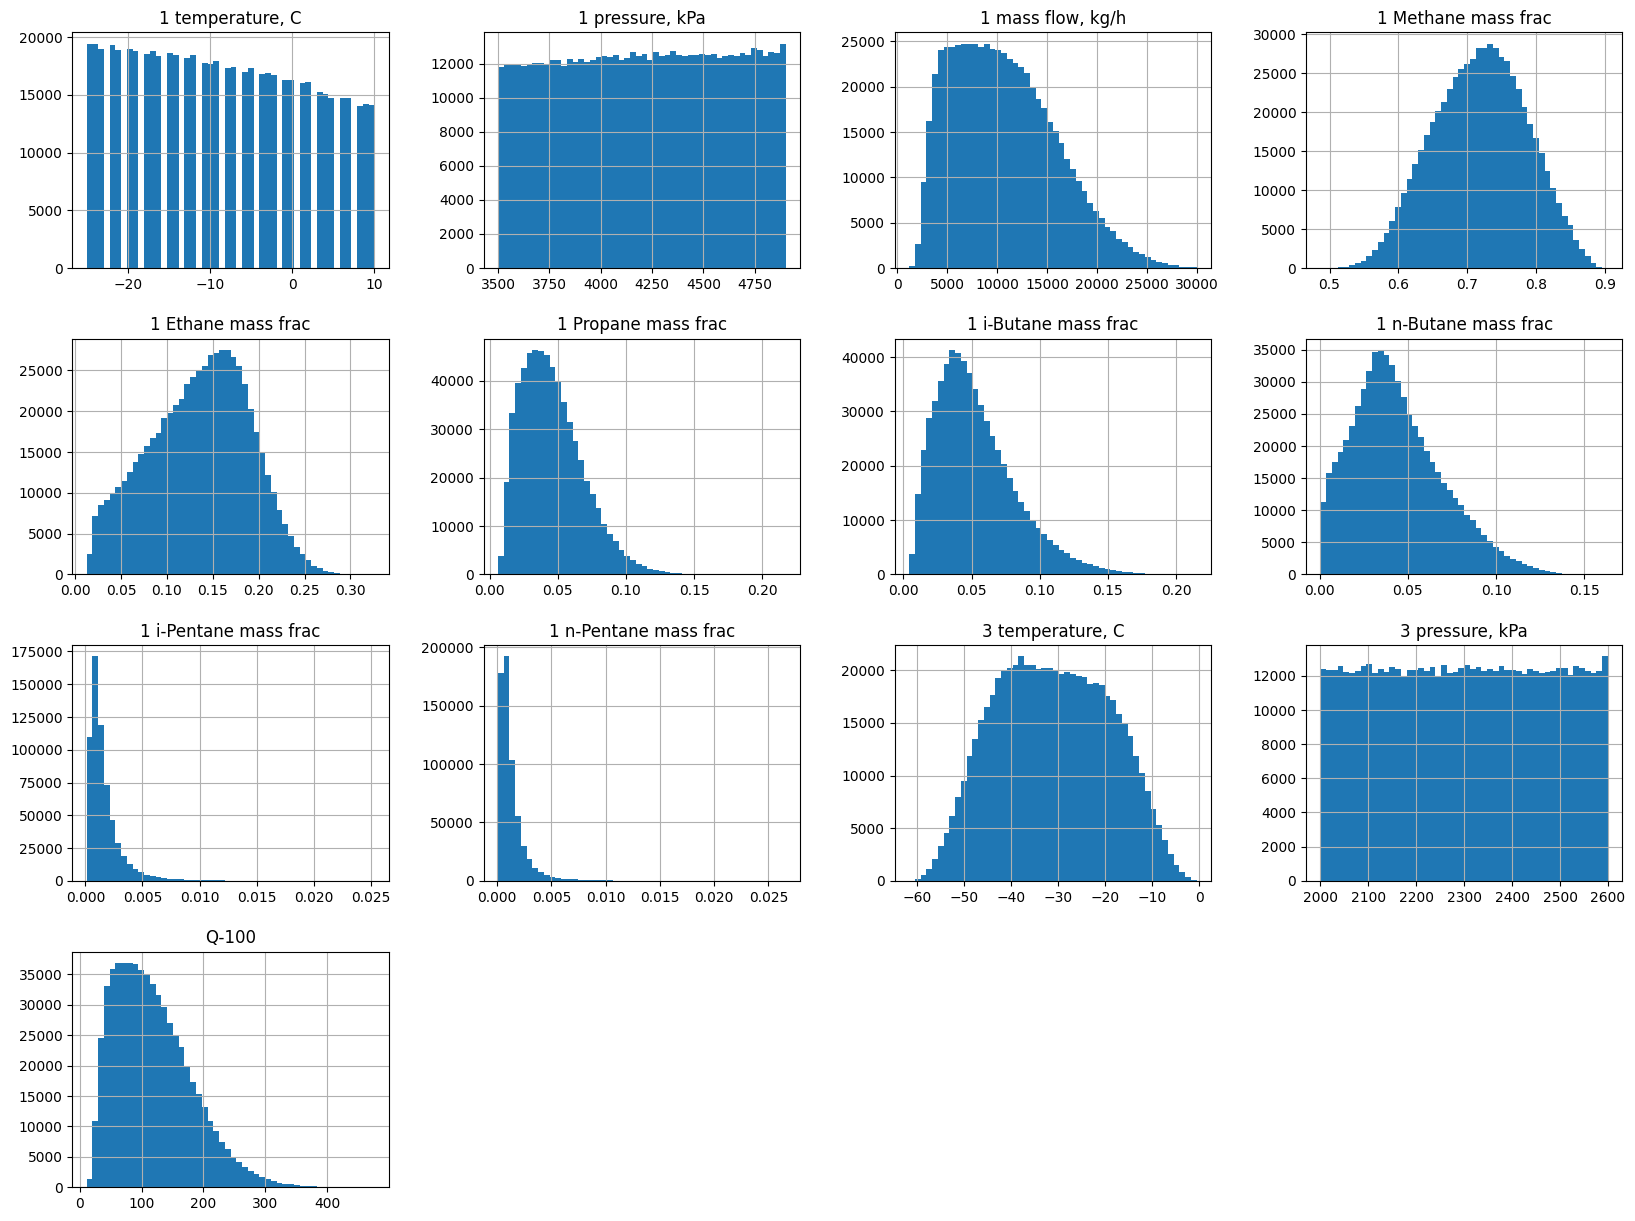

In [94]:
expander_power_data.hist(bins=50, figsize=(20, 15));

In [95]:
corr_matrix = expander_power_data.corr()

corr_matrix['Q-100'].sort_values(ascending=False)

Q-100                    1.000000
1 mass flow, kg/h        0.912382
1 i-Pentane mass frac    0.304179
1 n-Pentane mass frac    0.301533
1 pressure, kPa          0.229844
1 temperature, C         0.204798
1 Propane mass frac      0.162204
1 i-Butane mass frac     0.137107
3 temperature, C         0.060753
1 n-Butane mass frac     0.006101
1 Ethane mass frac      -0.023113
1 Methane mass frac     -0.112229
3 pressure, kPa         -0.235633
Name: Q-100, dtype: float64

In [96]:
## Тестовая и обучающая выборки
X = expander_power_data[[
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
]]

y = expander_power_data[[
    'Q-100'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac', '1 n-Pentane mass frac',
    '3 temperature, C', '3 pressure, kPa'
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 12), (494360, 1))

In [97]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
expander_power_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
expander_power_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
expander_power_model.fit(X_train_normal, y_train, epochs=10)

Epoch 1/10
15449/15449 [==============================] - 32s 2ms/step - loss: 1.8433 - mae: 1.8433
Epoch 2/10
15449/15449 [==============================] - 39s 3ms/step - loss: 0.9714 - mae: 0.9714
Epoch 3/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.8441 - mae: 0.8441
Epoch 4/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.7716 - mae: 0.7716
Epoch 5/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.7051 - mae: 0.7051
Epoch 6/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.6567 - mae: 0.6567
Epoch 7/10
15449/15449 [==============================] - 35s 2ms/step - loss: 0.6155 - mae: 0.6155
Epoch 8/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5959 - mae: 0.5959
Epoch 9/10
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5655 - mae: 0.5655
Epoch 10/10
15449/15449 [==============================] - 34s 2ms/step - loss: 0.5390 - mae: 0.5390

In [98]:
y_pred = expander_power_model.predict(X_test_normal)

3863/3863 [==============================] - 4s 894us/step


In [110]:
x = 12356
pred = y_pred[x]
pred[0]

42.976284

In [111]:
test = y_test.iloc[x]
test['Q-100']

43.14102883744545

In [112]:
expander_power_model.save('./models/low_temp_dist_24_04/expander_power_model.h5')

## Предсказание температуры верха колонны

In [11]:
column_top_temp_data = data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
    '16 temperature, C'
]]

In [13]:
column_top_temp_data.describe()

,"2 temperature, C","2 pressure, kPa","2 mass flow, kg/h",2 Methane mass frac,2 Ethane mass frac,2 Propane mass frac,2 i-Butane mass frac,2 n-Butane mass frac,2 i-Pentane mass frac,2 n-Pentane mass frac,...,"3 mass flow, kg/h",3 Methane mass frac,3 Ethane mass frac,3 Propane mass frac,3 i-Butane mass frac,3 n-Butane mass frac,3 i-Pentane mass frac,3 n-Pentane mass frac,Comp Fraction,"16 temperature, C"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,6804.969926,0.105631,0.102783,0.112368,0.287814,0.334335,0.027942,0.029127,...,10708.440240,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,0.069023,-30.749420
std,10.266356,403.397921,3873.795315,0.020240,0.046631,0.052751,0.125645,0.148774,0.020895,0.023613,...,5156.225297,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,0.037513,10.778405
min,-25.000000,3500.000000,0.000000,0.060192,0.007316,0.020030,0.037675,0.005641,0.003541,0.003695,...,1178.371232,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,0.010000,-61.141856
25%,-17.000000,3860.000000,3691.914667,0.090640,0.068499,0.071439,0.192450,0.226872,0.015078,0.015322,...,6520.828264,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,0.037278,-39.123012
50%,-9.000000,4211.000000,6192.395464,0.103563,0.102614,0.107293,0.282657,0.352001,0.022833,0.023243,...,10148.332833,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,0.064995,-30.980103
75%,0.000000,4557.000000,9389.228804,0.118898,0.134184,0.144229,0.370408,0.444107,0.033622,0.034568,...,14193.118168,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,0.097915,-22.262242
max,10.000000,4900.000000,23148.669181,0.186983,0.343767,0.431563,0.775322,0.764180,0.333591,0.461907,...,29970.000000,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,0.149999,23.994056


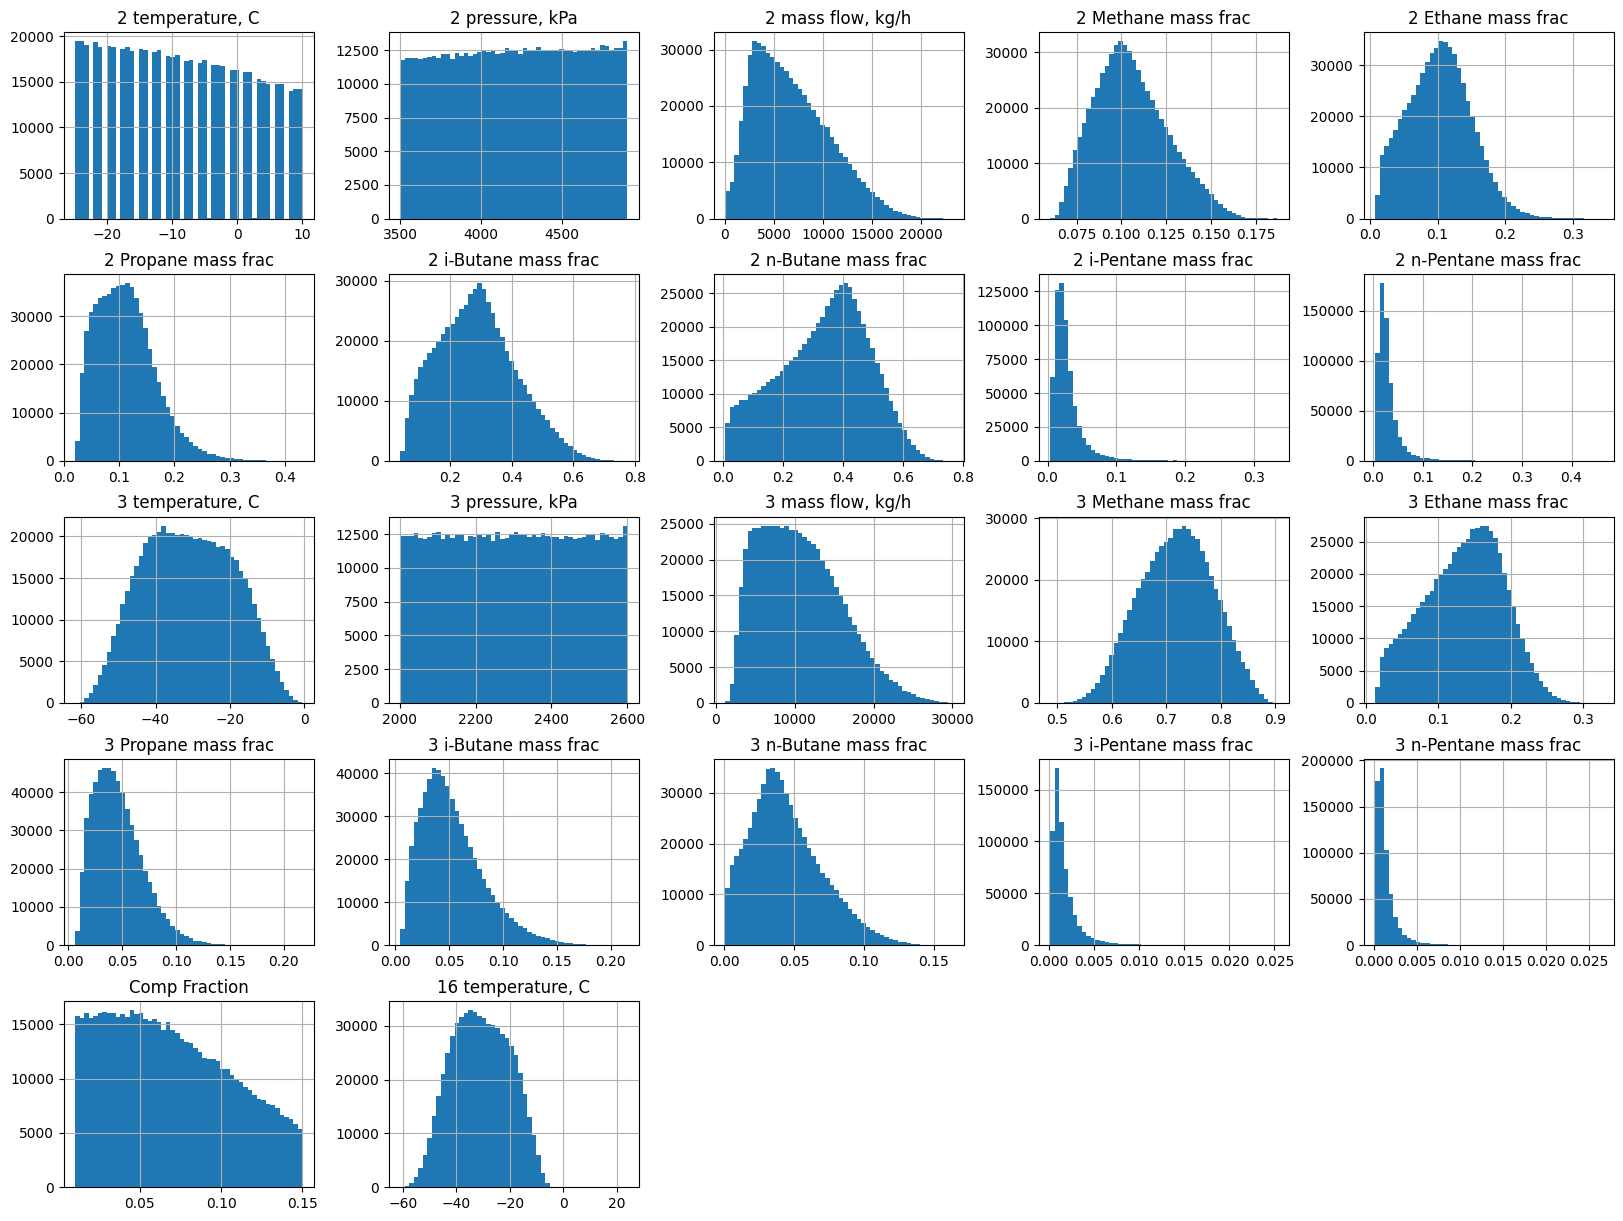

In [14]:
column_top_temp_data.hist(bins=50, figsize=(20, 15));

In [15]:
corr_matrix = column_top_temp_data.corr()

corr_matrix['16 temperature, C'].sort_values(ascending=False)

16 temperature, C        1.000000
3 temperature, C         0.963915
2 temperature, C         0.911989
3 n-Butane mass frac     0.550340
3 i-Butane mass frac     0.504529
3 i-Pentane mass frac    0.382739
3 n-Pentane mass frac    0.374877
3 Propane mass frac      0.336210
3 Ethane mass frac       0.249036
3 mass flow, kg/h        0.133440
2 n-Butane mass frac     0.111336
2 n-Pentane mass frac    0.110330
3 pressure, kPa          0.107837
2 i-Pentane mass frac    0.097522
2 i-Butane mass frac     0.064349
2 Propane mass frac     -0.107653
2 Ethane mass frac      -0.137464
2 mass flow, kg/h       -0.177653
Comp Fraction           -0.229420
2 pressure, kPa         -0.297557
3 Methane mass frac     -0.762650
2 Methane mass frac     -0.849972
Name: 16 temperature, C, dtype: float64

In [17]:
## Тестовая и обучающая выборки
X = column_top_temp_data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
]]

y = column_top_temp_data[[
    '16 temperature, C'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 21), (494360, 1))

In [31]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
column_top_temp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(21, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
column_top_temp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
column_top_temp_model.fit(X_train_normal, y_train, epochs=30)

Epoch 1/30
15449/15449 [==============================] - 31s 2ms/step - loss: 0.4861 - mae: 0.4861
Epoch 2/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.2676 - mae: 0.2676
Epoch 3/30
15449/15449 [==============================] - 32s 2ms/step - loss: 0.2255 - mae: 0.2255
Epoch 4/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.2072 - mae: 0.2072
Epoch 5/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.1870 - mae: 0.1870
Epoch 6/30
15449/15449 [==============================] - 32s 2ms/step - loss: 0.1773 - mae: 0.1773
Epoch 7/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.1687 - mae: 0.1687
Epoch 8/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.1629 - mae: 0.1629
Epoch 9/30
15449/15449 [==============================] - 33s 2ms/step - loss: 0.1578 - mae: 0.1578
Epoch 10/30
15449/15449 [==============================] - 34s 2ms/step - loss: 0.1515 - mae: 0.1515

In [32]:
y_pred = column_top_temp_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 857us/step


In [45]:
x = 21356
pred = y_pred[x]
pred[0]

-35.21451

In [46]:
test = y_test.iloc[x]
test['16 temperature, C']

-35.201512103218704

In [47]:
column_top_temp_model.save('./models/low_temp_dist_24_04/column_top_temp_model.h5')

## Предсказание температуры низа колонны

In [53]:
column_bot_temp_data = data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
    '16 temperature, C',
    '17 temperature, C'
]]

In [54]:
column_bot_temp_data.describe()

,"2 temperature, C","2 pressure, kPa","2 mass flow, kg/h",2 Methane mass frac,2 Ethane mass frac,2 Propane mass frac,2 i-Butane mass frac,2 n-Butane mass frac,2 i-Pentane mass frac,2 n-Pentane mass frac,...,3 Methane mass frac,3 Ethane mass frac,3 Propane mass frac,3 i-Butane mass frac,3 n-Butane mass frac,3 i-Pentane mass frac,3 n-Pentane mass frac,Comp Fraction,"16 temperature, C","17 temperature, C"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,6804.969926,0.105631,0.102783,0.112368,0.287814,0.334335,0.027942,0.029127,...,0.718432,0.134965,0.046194,0.052959,0.044415,0.001691,0.001344,0.069023,-30.749420,62.942581
std,10.266356,403.397921,3873.795315,0.020240,0.046631,0.052751,0.125645,0.148774,0.020895,0.023613,...,0.067038,0.054089,0.022804,0.029159,0.025668,0.001615,0.001423,0.037513,10.778405,31.270850
min,-25.000000,3500.000000,0.000000,0.060192,0.007316,0.020030,0.037675,0.005641,0.003541,0.003695,...,0.486766,0.012521,0.006105,0.004229,0.000462,0.000115,0.000077,0.010000,-61.141856,-40.867701
25%,-17.000000,3860.000000,3691.914667,0.090640,0.068499,0.071439,0.192450,0.226872,0.015078,0.015322,...,0.670146,0.095429,0.028730,0.031357,0.025633,0.000742,0.000557,0.037278,-39.123012,47.185463
50%,-9.000000,4211.000000,6192.395464,0.103563,0.102614,0.107293,0.282657,0.352001,0.022833,0.023243,...,0.720280,0.139257,0.042838,0.047637,0.040661,0.001222,0.000931,0.064995,-30.980103,73.636333
75%,0.000000,4557.000000,9389.228804,0.118898,0.134184,0.144229,0.370408,0.444107,0.033622,0.034568,...,0.767161,0.175188,0.059833,0.069162,0.060084,0.002049,0.001602,0.097915,-22.262242,86.128257
max,10.000000,4900.000000,23148.669181,0.186983,0.343767,0.431563,0.775322,0.764180,0.333591,0.461907,...,0.903853,0.325984,0.216986,0.215197,0.163427,0.025310,0.026572,0.149999,23.994056,130.982719


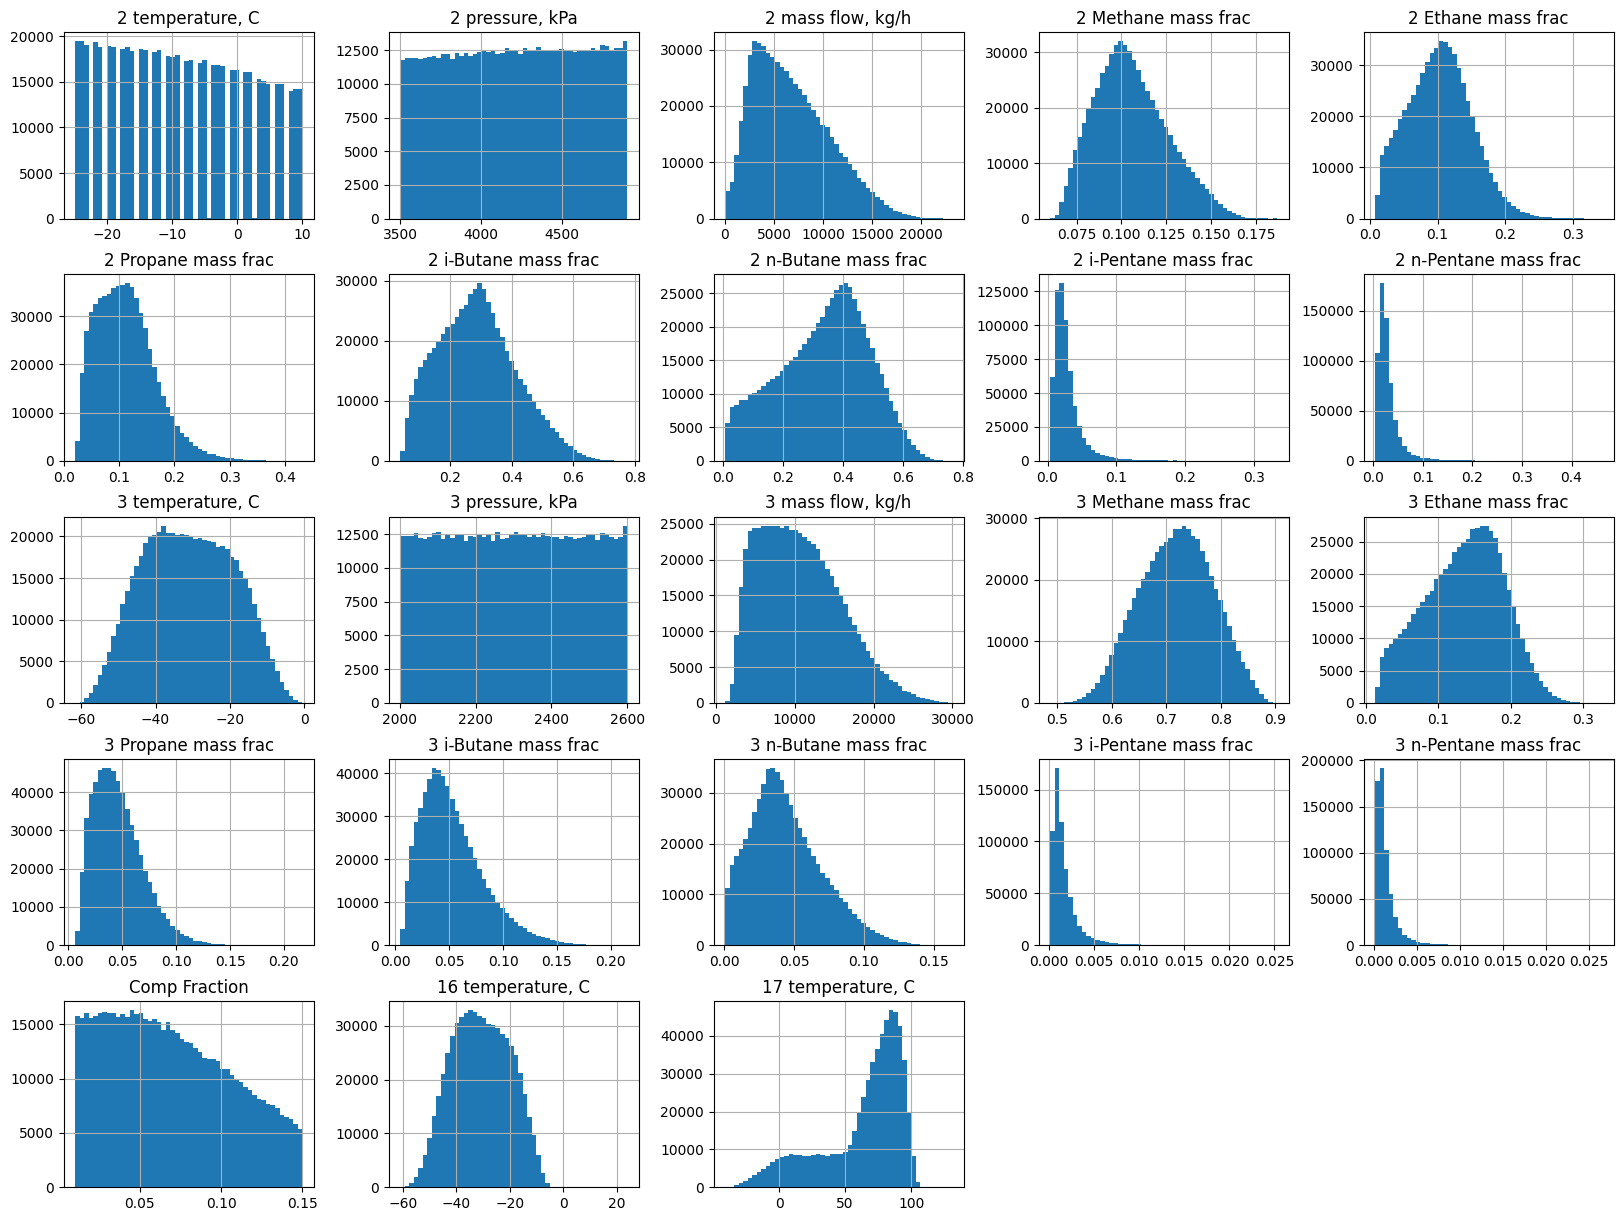

In [55]:
column_bot_temp_data.hist(bins=50, figsize=(20, 15));

In [56]:
corr_matrix = column_bot_temp_data.corr()

corr_matrix['17 temperature, C'].sort_values(ascending=False)

17 temperature, C        1.000000
3 Ethane mass frac       0.249307
2 Ethane mass frac       0.236625
16 temperature, C        0.167611
2 temperature, C         0.039808
3 temperature, C         0.036118
3 n-Butane mass frac     0.031127
2 n-Butane mass frac     0.012430
3 n-Pentane mass frac    0.007528
3 i-Pentane mass frac    0.004896
3 pressure, kPa          0.003499
2 mass flow, kg/h       -0.001074
2 pressure, kPa         -0.001329
3 mass flow, kg/h       -0.004970
2 n-Pentane mass frac   -0.008750
2 i-Pentane mass frac   -0.011507
2 Methane mass frac     -0.014622
3 i-Butane mass frac    -0.027118
2 i-Butane mass frac    -0.055174
3 Propane mass frac     -0.085079
2 Propane mass frac     -0.098729
3 Methane mass frac     -0.172610
Comp Fraction           -0.671743
Name: 17 temperature, C, dtype: float64

In [58]:
## Тестовая и обучающая выборки
X = column_bot_temp_data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
    '16 temperature, C',
]]

y = column_bot_temp_data[[
    '17 temperature, C'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac', 
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', 'Comp Fraction',
    '16 temperature, C',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 22), (494360, 1))

In [61]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
column_bot_temp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(22, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
column_bot_temp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
column_bot_temp_model.fit(X_train_normal, y_train, epochs=30)

Epoch 1/30
15449/15449 [==============================] - 33s 2ms/step - loss: 1.7802 - mae: 1.7802
Epoch 2/30
15449/15449 [==============================] - 35s 2ms/step - loss: 1.0294 - mae: 1.0294
Epoch 3/30
15449/15449 [==============================] - 35s 2ms/step - loss: 0.8822 - mae: 0.8822
Epoch 4/30
15449/15449 [==============================] - 35s 2ms/step - loss: 0.8107 - mae: 0.8107
Epoch 5/30
15449/15449 [==============================] - 35s 2ms/step - loss: 0.7503 - mae: 0.7503
Epoch 6/30
15449/15449 [==============================] - 36s 2ms/step - loss: 0.7111 - mae: 0.7111
Epoch 7/30
15449/15449 [==============================] - 35s 2ms/step - loss: 0.6748 - mae: 0.6748
Epoch 8/30
15449/15449 [==============================] - 36s 2ms/step - loss: 0.6488 - mae: 0.6488
Epoch 9/30
15449/15449 [==============================] - 38s 2ms/step - loss: 0.6271 - mae: 0.6271
Epoch 10/30
15449/15449 [==============================] - 37s 2ms/step - loss: 0.6122 - mae: 0.6122

In [62]:
y_pred = column_bot_temp_model.predict(X_test_normal)

3863/3863 [==============================] - 4s 1ms/step


In [69]:
x = 2105
pred = y_pred[x]
pred[0]

61.11014

In [70]:
test = y_test.iloc[x]
test['17 temperature, C']

61.07425207497744

In [71]:
column_bot_temp_model.save('./models/low_temp_dist_24_04/column_bot_temp_model.h5')

## Предсказание массового расхода верхнего продукта колонны

In [37]:
column_top_mass_flow_data = data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C', '16 mass flow, kg/h',
    '17 temperature, C'
]]

In [38]:
column_top_mass_flow_data.describe()

,"2 temperature, C","2 pressure, kPa","2 mass flow, kg/h",2 Methane mass frac,2 Ethane mass frac,2 Propane mass frac,2 i-Butane mass frac,2 n-Butane mass frac,2 i-Pentane mass frac,2 n-Pentane mass frac,...,"3 Ethane mass flow, kg/h","3 Propane mass flow, kg/h","3 i-Butane mass flow, kg/h","3 n-Butane mass flow, kg/h","3 i-Pentane mass flow, kg/h","3 n-Pentane mass flow, kg/h",Comp Fraction,"16 temperature, C","16 mass flow, kg/h","17 temperature, C"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,6804.969926,0.105631,0.102783,0.112368,0.287814,0.334335,0.027942,0.029127,...,1460.298519,517.565783,589.143102,471.614328,20.746357,16.683410,0.069023,-30.749420,11265.927589,62.942581
std,10.266356,403.397921,3873.795315,0.020240,0.046631,0.052751,0.125645,0.148774,0.020895,0.023613,...,990.738355,424.436118,502.295492,384.349698,29.766231,26.292927,0.037513,10.778405,5074.349812,31.270850
min,-25.000000,3500.000000,0.000000,0.060192,0.007316,0.020030,0.037675,0.005641,0.003541,0.003695,...,29.271809,14.877799,8.414354,1.505019,0.210124,0.177216,0.010000,-61.141856,1782.939801,-40.867701
25%,-17.000000,3860.000000,3691.914667,0.090640,0.068499,0.071439,0.192450,0.226872,0.015078,0.015322,...,704.857361,222.580618,241.889471,196.335571,5.721252,4.311031,0.037278,-39.123012,7052.366237,47.185463
50%,-9.000000,4211.000000,6192.395464,0.103563,0.102614,0.107293,0.282657,0.352001,0.022833,0.023243,...,1233.954705,395.241341,439.921803,364.488321,11.569586,8.797048,0.064995,-30.980103,10949.571011,73.636333
75%,0.000000,4557.000000,9389.228804,0.118898,0.134184,0.144229,0.370408,0.444107,0.033622,0.034568,...,1990.463164,678.562980,772.651250,633.447974,23.585255,18.377524,0.097915,-22.262242,14983.121941,86.128257
max,10.000000,4900.000000,23148.669181,0.186983,0.343767,0.431563,0.775322,0.764180,0.333591,0.461907,...,8210.145468,5160.041992,5662.226921,3388.108050,675.411675,591.001933,0.149999,23.994056,29499.756524,130.982719


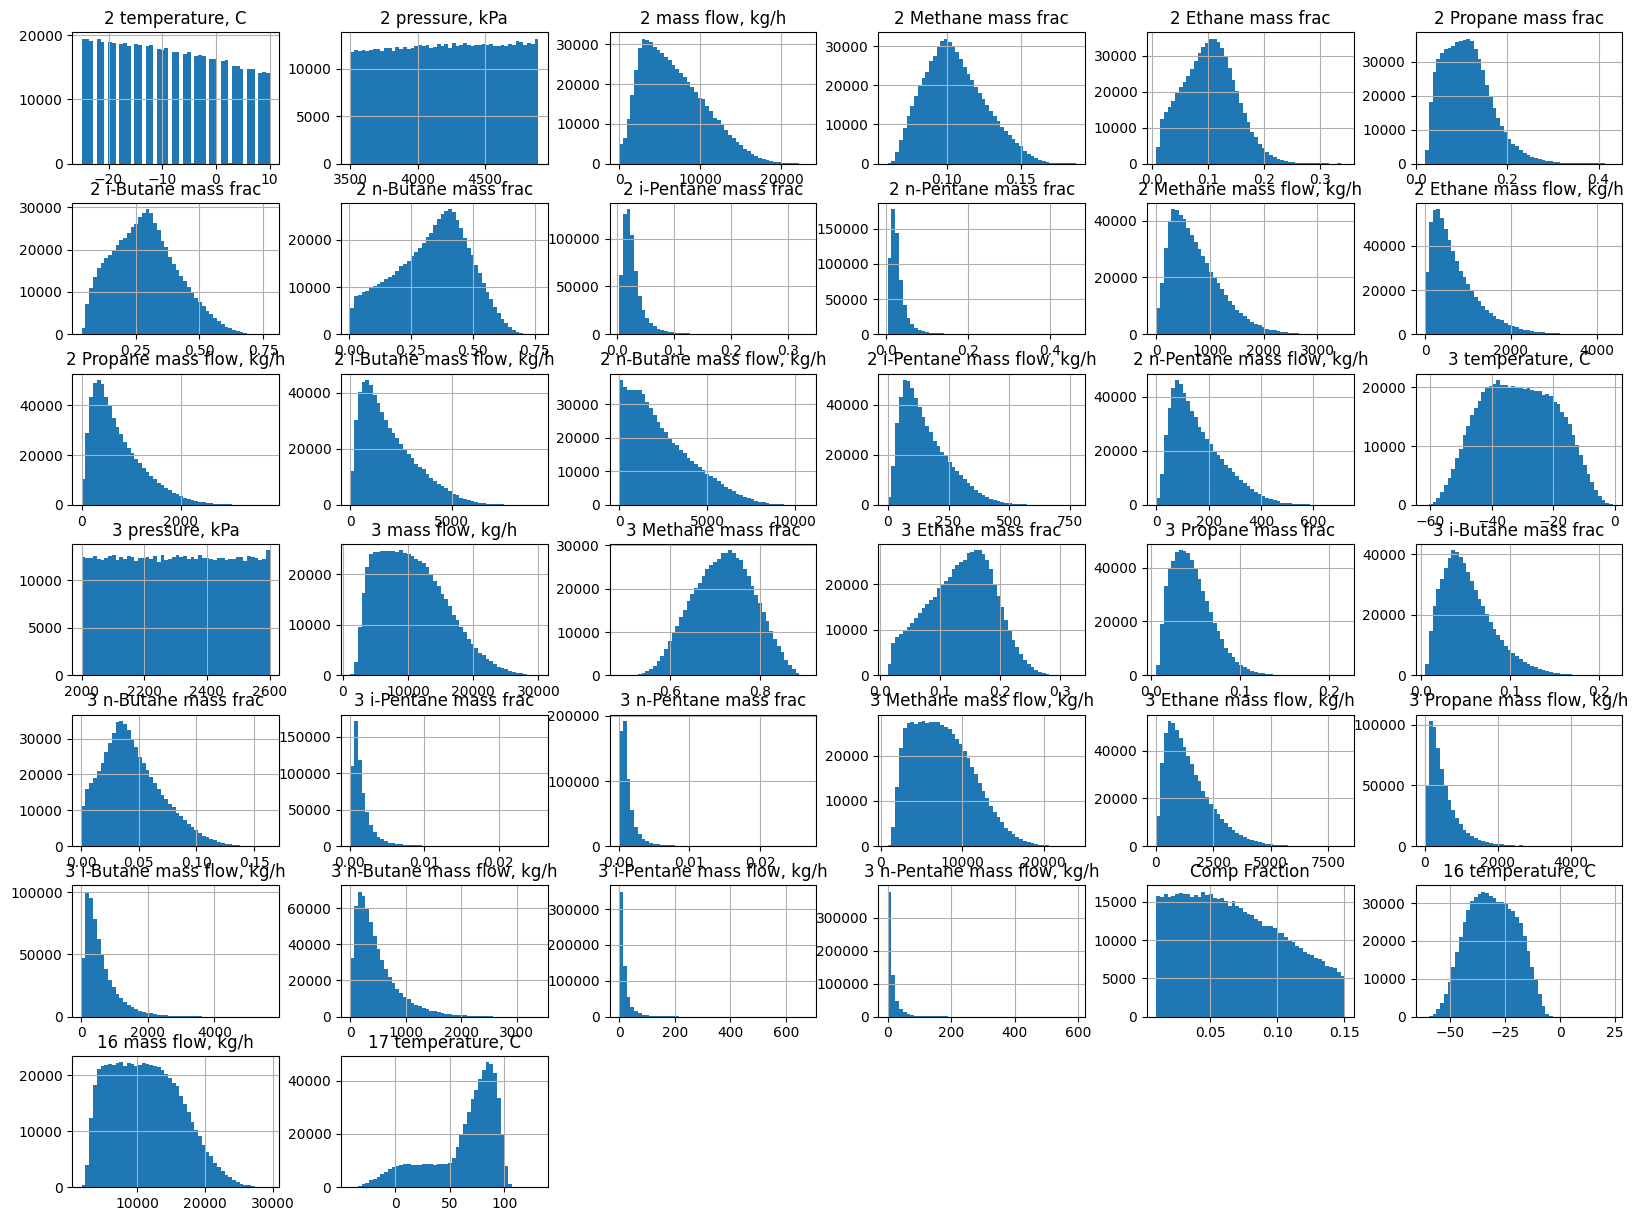

In [39]:
column_top_mass_flow_data.hist(bins=50, figsize=(20, 15));

In [40]:
corr_matrix = column_top_mass_flow_data.corr()

corr_matrix['16 mass flow, kg/h'].sort_values(ascending=False)

16 mass flow, kg/h             1.000000
3 mass flow, kg/h              0.982968
3 Methane mass flow, kg/h      0.964118
3 Ethane mass flow, kg/h       0.765251
3 Propane mass flow, kg/h      0.678066
3 i-Butane mass flow, kg/h     0.617524
2 n-Pentane mass flow, kg/h    0.582720
2 i-Pentane mass flow, kg/h    0.570968
3 i-Pentane mass flow, kg/h    0.518095
3 n-Butane mass flow, kg/h     0.517591
3 n-Pentane mass flow, kg/h    0.488337
2 mass flow, kg/h              0.391336
2 Propane mass flow, kg/h      0.375149
2 i-Butane mass flow, kg/h     0.341104
2 Ethane mass flow, kg/h       0.330365
2 Methane mass flow, kg/h      0.325915
2 n-Pentane mass frac          0.240529
2 i-Pentane mass frac          0.239891
3 i-Pentane mass frac          0.232116
3 n-Pentane mass frac          0.229493
2 n-Butane mass flow, kg/h     0.226191
3 Propane mass frac            0.138228
3 temperature, C               0.109410
2 temperature, C               0.106571
3 Ethane mass frac             0.100761


In [41]:
## Тестовая и обучающая выборки
X = column_top_mass_flow_data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C',
    '17 temperature, C'
]]

y = column_top_mass_flow_data[[
    '16 mass flow, kg/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C',
    '17 temperature, C'
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 37), (494360, 1))

In [42]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
column_top_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(37, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
column_top_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
column_top_mass_flow_model.fit(X_train_normal, y_train, epochs=100)

Epoch 1/100
15449/15449 [==============================] - 18s 1ms/step - loss: 212.2658 - mae: 212.2658
Epoch 2/100
15449/15449 [==============================] - 18s 1ms/step - loss: 56.0055 - mae: 56.0055
Epoch 3/100
15449/15449 [==============================] - 21s 1ms/step - loss: 51.7249 - mae: 51.7249
Epoch 4/100
15449/15449 [==============================] - 20s 1ms/step - loss: 50.8431 - mae: 50.8431
Epoch 5/100
15449/15449 [==============================] - 20s 1ms/step - loss: 49.2872 - mae: 49.2872
Epoch 6/100
15449/15449 [==============================] - 21s 1ms/step - loss: 46.5579 - mae: 46.5579
Epoch 7/100
15449/15449 [==============================] - 20s 1ms/step - loss: 41.9295 - mae: 41.9295
Epoch 8/100
15449/15449 [==============================] - 20s 1ms/step - loss: 39.4707 - mae: 39.4707
Epoch 9/100
15449/15449 [==============================] - 20s 1ms/step - loss: 38.7817 - mae: 38.7817
Epoch 10/100
15449/15449 [==============================] - 20s 1ms/ste

In [43]:
y_pred = column_top_mass_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 842us/step


In [53]:
x = 56473
pred = y_pred[x]
pred[0]

10144.405

In [54]:
test = y_test.iloc[x]
test['16 mass flow, kg/h']

10138.731816503505

In [55]:
test['16 mass flow, kg/h'] - pred[0]

-5.673456933995112

In [56]:
column_top_mass_flow_model.save('./models/low_temp_dist_24_04/column_top_mass_flow_model.h5')

## Предсказание состава верхнего продукта

In [47]:
column_top_prod_composition_data = data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C', '16 mass flow, kg/h', '16 Methane mass flow, kg/h', '16 Ethane mass flow, kg/h',
    '16 Propane mass flow, kg/h', '16 i-Butane mass flow, kg/h', '16 n-Butane mass flow, kg/h',
    '16 i-Pentane mass flow, kg/h', '16 n-Pentane mass flow, kg/h',
    '17 temperature, C', '17 mass flow, kg/h'
]]

In [48]:
column_top_prod_composition_data.describe()

,"2 temperature, C","2 pressure, kPa","2 mass flow, kg/h",2 Methane mass frac,2 Ethane mass frac,2 Propane mass frac,2 i-Butane mass frac,2 n-Butane mass frac,2 i-Pentane mass frac,2 n-Pentane mass frac,...,"16 mass flow, kg/h","16 Methane mass flow, kg/h","16 Ethane mass flow, kg/h","16 Propane mass flow, kg/h","16 i-Butane mass flow, kg/h","16 n-Butane mass flow, kg/h","16 i-Pentane mass flow, kg/h","16 n-Pentane mass flow, kg/h","17 temperature, C","17 mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,...,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,6804.969926,0.105631,0.102783,0.112368,0.287814,0.334335,0.027942,0.029127,...,11265.927589,8310.206591,1782.810303,487.907137,402.401763,272.596865,6.176158,3.828772,62.942581,6247.489915
std,10.266356,403.397921,3873.795315,0.020240,0.046631,0.052751,0.125645,0.148774,0.020895,0.023613,...,5074.349812,3749.771800,1184.036112,376.187313,360.861515,256.305133,10.883221,7.822056,31.270850,3295.702566
min,-25.000000,3500.000000,0.000000,0.060192,0.007316,0.020030,0.037675,0.005641,0.003541,0.003695,...,1782.939801,1390.165332,35.225860,15.160028,7.276531,0.434292,0.029547,0.016094,-40.867701,0.018227
25%,-17.000000,3860.000000,3691.914667,0.090640,0.068499,0.071439,0.192450,0.226872,0.015078,0.015322,...,7052.366237,5203.015377,856.777810,221.219933,157.520532,95.288100,1.243073,0.649181,47.185463,3560.519692
50%,-9.000000,4211.000000,6192.395464,0.103563,0.102614,0.107293,0.282657,0.352001,0.022833,0.023243,...,10949.571011,8069.982588,1522.925745,384.849923,291.964559,191.760745,2.852698,1.573217,73.636333,5774.958748
75%,0.000000,4557.000000,9389.228804,0.118898,0.134184,0.144229,0.370408,0.444107,0.033622,0.034568,...,14983.121941,11029.911315,2479.655830,643.844264,525.300258,364.423441,6.676839,3.910446,86.128257,8491.927659
max,10.000000,4900.000000,23148.669181,0.186983,0.343767,0.431563,0.775322,0.764180,0.333591,0.461907,...,29499.756524,23881.665600,8720.118840,4796.711867,4094.287975,3011.690345,408.610651,297.947523,130.982719,19800.957889


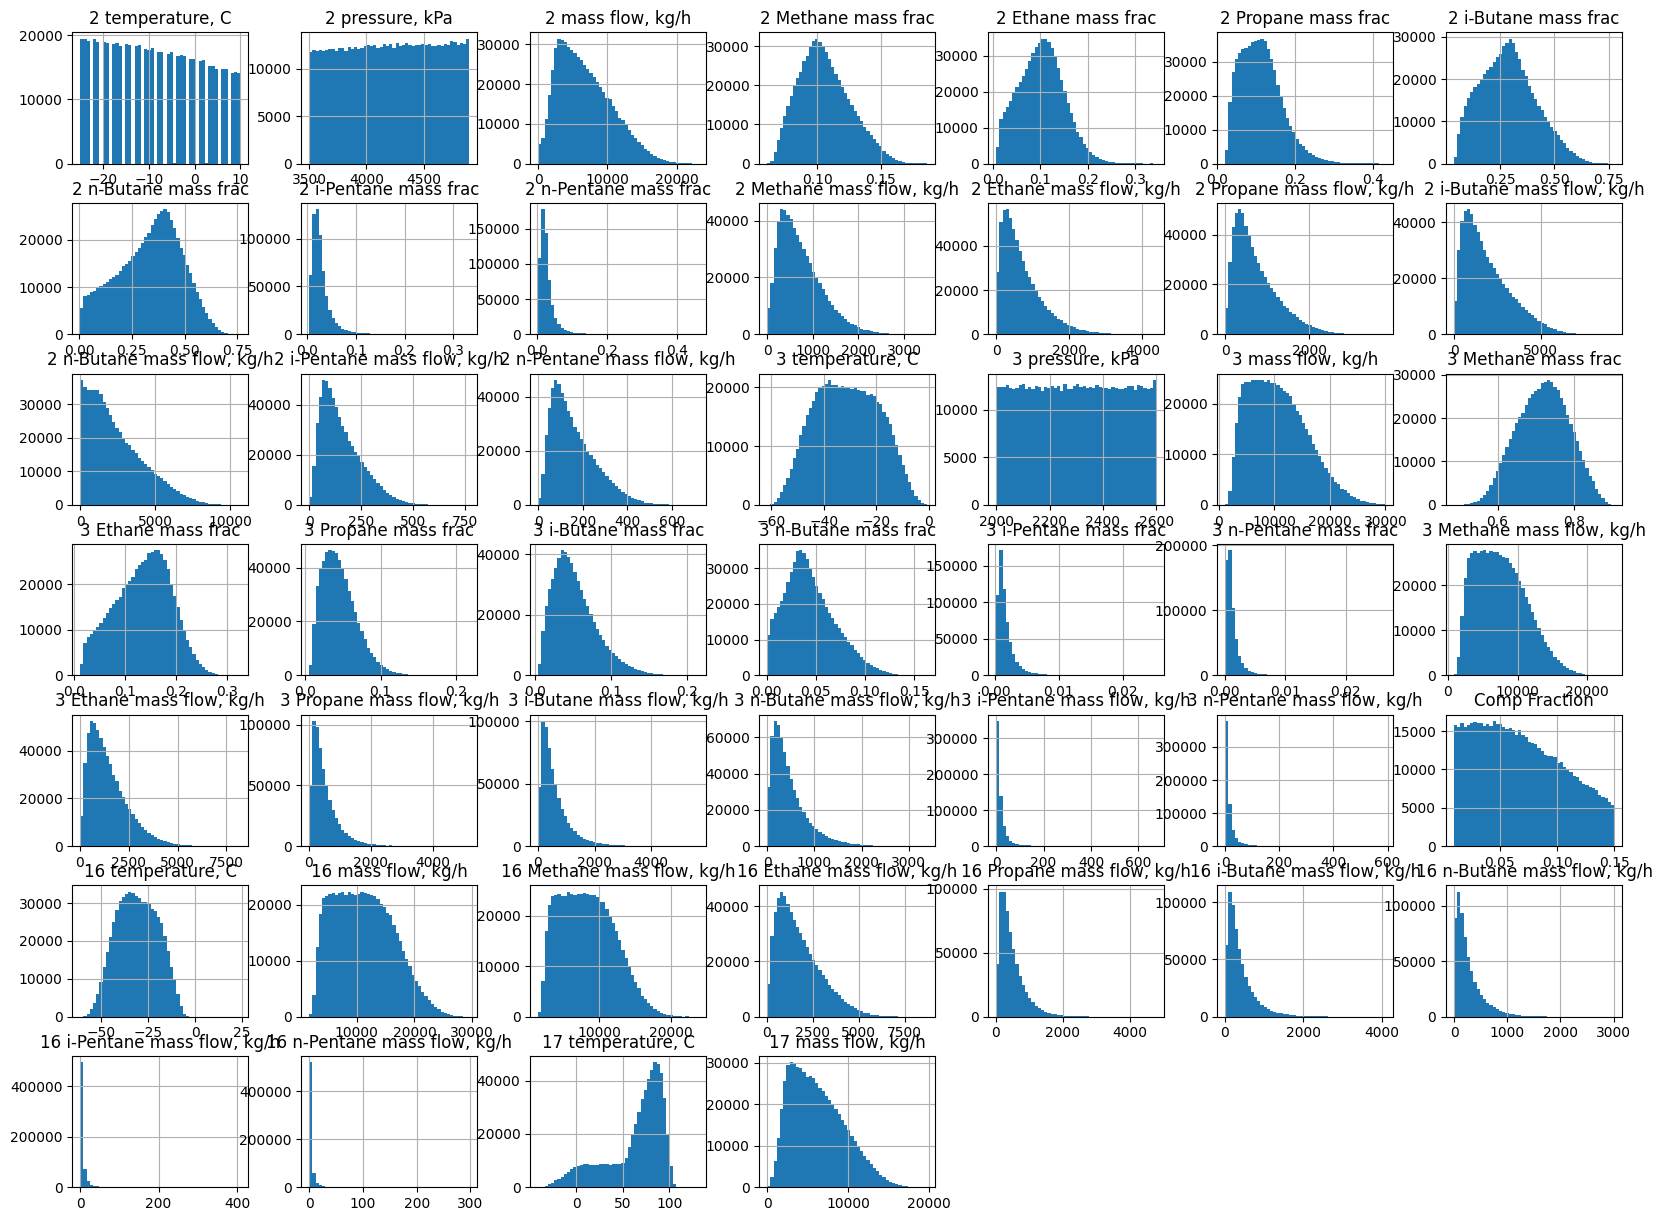

In [49]:
column_top_prod_composition_data.hist(bins=50, figsize=(20, 15));

In [50]:
corr_matrix = column_top_prod_composition_data.corr()

corr_matrix['16 Methane mass flow, kg/h'].sort_values(ascending=False)

16 Methane mass flow, kg/h      1.000000
3 Methane mass flow, kg/h       0.992817
16 mass flow, kg/h              0.968956
3 mass flow, kg/h               0.960781
3 Propane mass flow, kg/h       0.622542
3 Ethane mass flow, kg/h        0.612369
16 Propane mass flow, kg/h      0.607018
2 n-Pentane mass flow, kg/h     0.598874
2 i-Pentane mass flow, kg/h     0.589378
3 i-Butane mass flow, kg/h      0.562424
16 Ethane mass flow, kg/h       0.556261
17 mass flow, kg/h              0.501477
16 i-Butane mass flow, kg/h     0.488839
3 n-Butane mass flow, kg/h      0.484972
3 i-Pentane mass flow, kg/h     0.466604
3 n-Pentane mass flow, kg/h     0.436405
2 mass flow, kg/h               0.417042
2 Propane mass flow, kg/h       0.391196
16 n-Butane mass flow, kg/h     0.379145
2 Methane mass flow, kg/h       0.375146
2 i-Butane mass flow, kg/h      0.365867
16 i-Pentane mass flow, kg/h    0.362890
16 n-Pentane mass flow, kg/h    0.324215
2 n-Butane mass flow, kg/h      0.266198
2 Ethane mass fl

In [51]:
## Тестовая и обучающая выборки
X = column_top_prod_composition_data[[
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C', '16 mass flow, kg/h', 
    '17 temperature, C', '17 mass flow, kg/h', 
]]

y = column_top_prod_composition_data[[
    '16 Methane mass flow, kg/h', '16 Ethane mass flow, kg/h',
    '16 Propane mass flow, kg/h', '16 i-Butane mass flow, kg/h', '16 n-Butane mass flow, kg/h',
    '16 i-Pentane mass flow, kg/h', '16 n-Pentane mass flow, kg/h',
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    '2 temperature, C', '2 pressure, kPa', '2 mass flow, kg/h', '2 Methane mass frac', '2 Ethane mass frac',
    '2 Propane mass frac', '2 i-Butane mass frac', '2 n-Butane mass frac', '2 i-Pentane mass frac',
    '2 n-Pentane mass frac',
    '2 Methane mass flow, kg/h', '2 Ethane mass flow, kg/h', '2 Propane mass flow, kg/h', '2 i-Butane mass flow, kg/h',
    '2 n-Butane mass flow, kg/h', '2 i-Pentane mass flow, kg/h', '2 n-Pentane mass flow, kg/h',
    '3 temperature, C', '3 pressure, kPa', '3 mass flow, kg/h', '3 Methane mass frac', '3 Ethane mass frac',
    '3 Propane mass frac', '3 i-Butane mass frac', '3 n-Butane mass frac', '3 i-Pentane mass frac',
    '3 n-Pentane mass frac', '3 Methane mass flow, kg/h', '3 Ethane mass flow, kg/h', '3 Propane mass flow, kg/h',
    '3 i-Butane mass flow, kg/h', '3 n-Butane mass flow, kg/h', '3 i-Pentane mass flow, kg/h',
    '3 n-Pentane mass flow, kg/h',
    'Comp Fraction',
    '16 temperature, C', '16 mass flow, kg/h', 
    '17 temperature, C', '17 mass flow, kg/h', 
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 39), (494360, 7))

In [52]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
column_top_prod_composition_model = tf.keras.Sequential([
    tf.keras.layers.Dense(39, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(7)
])

# 2. Compile the model
column_top_prod_composition_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
column_top_prod_composition_model.fit(X_train_normal, y_train, epochs=80)

Epoch 1/80
15449/15449 [==============================] - 36s 2ms/step - loss: 141.4022 - mae: 141.4022
Epoch 2/80
15449/15449 [==============================] - 39s 2ms/step - loss: 66.0467 - mae: 66.0467
Epoch 3/80
15449/15449 [==============================] - 37s 2ms/step - loss: 44.3262 - mae: 44.3262
Epoch 4/80
15449/15449 [==============================] - 37s 2ms/step - loss: 30.2401 - mae: 30.2401
Epoch 5/80
15449/15449 [==============================] - 37s 2ms/step - loss: 14.5094 - mae: 14.5094
Epoch 6/80
15449/15449 [==============================] - 40s 3ms/step - loss: 13.1469 - mae: 13.1469
Epoch 7/80
15449/15449 [==============================] - 41s 3ms/step - loss: 12.2701 - mae: 12.2701
Epoch 8/80
15449/15449 [==============================] - 41s 3ms/step - loss: 11.7536 - mae: 11.7536
Epoch 9/80
15449/15449 [==============================] - 40s 3ms/step - loss: 11.1052 - mae: 11.1052
Epoch 10/80
15449/15449 [==============================] - 41s 3ms/step - loss: 

In [53]:
y_pred = column_top_prod_composition_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 866us/step


In [54]:
x = 4312
pred = y_pred[x]
list(pred)

[5933.8745, 685.5641, 131.88046, 66.8898, 51.64408, 0.28606606, 0.7295853]

In [55]:
test = y_test.iloc[x]
test

16 Methane mass flow, kg/h      5962.268760
16 Ethane mass flow, kg/h        697.032220
16 Propane mass flow, kg/h       136.619140
16 i-Butane mass flow, kg/h       63.806614
16 n-Butane mass flow, kg/h       52.885764
16 i-Pentane mass flow, kg/h       0.189477
16 n-Pentane mass flow, kg/h       0.038432
Name: 369182, dtype: float64

In [56]:
sum(list(test.values))

6912.840406680827

In [57]:
sum(list(pred))

6870.868594765663

In [58]:
sum(list(test.values)) - sum(list(pred))

41.971811915163926

In [59]:
list(list(pred) / sum(list(pred)))

[0.863628,
 0.09977837,
 0.019194147,
 0.009735276,
 0.007516383,
 4.1634627e-05,
 0.0001061853]

In [60]:
list(list(test.values) / sum(list(test.values)))

[0.8624918860187613,
 0.10083152202686295,
 0.019763097644094712,
 0.009230158682000104,
 0.007650366674307004,
 2.7409483413921212e-05,
 5.559470560212102e-06]

In [63]:
column_top_prod_composition_model.save('./models/low_temp_dist_24_04/column_top_prod_composition_model.h5')

In [72]:
comp_flow = {
    'methane': 0.01,
    'ethane': 0.2,
    'propane': 0.32,
    'butane': 0.12
}

comp_flow.keys()

dict_keys(['methane', 'ethane', 'propane', 'butane'])